In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stat

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error

plt.rcParams['figure.figsize'] = 15, 10

import warnings
warnings.filterwarnings('ignore')

In [2]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Proportion'])
    return missing_data[missing_data['Total'] > 0]

def plot_categorical(feature, target_feature, effect_plot=sns.barplot):
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    count_ax, effect_ax = axes
    count_ax.set_title(f"{feature.name} count")
    sns.countplot(feature, ax=count_ax)
    effect_ax.set_title(f"{feature.name} effect on {target_feature.name}")
    effect_plot(x=feature, y=target_feature, ax=effect_ax)
    
def plot_real(feature):
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_title(f'{feature.name} distribution')
    sns.distplot(feature)

In [3]:
dtypes = {
    # Set ALL categorical Variables
    'MSSubClass':CategoricalDtype([20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]),
    'MSZoning':CategoricalDtype(['A', 'C (all)', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']),
    'Street': CategoricalDtype(['Grvl', 'Pave']),
    'Alley': CategoricalDtype(['None', 'Grvl', 'Pave'], ordered=True),
    'LotShape': CategoricalDtype(['Reg', 'IR1', 'IR2', 'IR3'], ordered=True),
    'LandContour': CategoricalDtype(['Low', 'Lvl', 'Bnk', 'HLS'], ordered=True),
    'Utilities': CategoricalDtype(['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ordered=True),
    'LotConfig': CategoricalDtype(['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3']),
    'LandSlope': CategoricalDtype(['Gtl', 'Mod', 'Sev'], ordered=True),
    'Neighborhood': CategoricalDtype(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']),
    'Condition1': CategoricalDtype(['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe']),
    'Condition2': CategoricalDtype(['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe']),
    'BldgType': CategoricalDtype(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']),
    'HouseStyle': CategoricalDtype(['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl']),
    'OverallQual': CategoricalDtype(range(1, 11), ordered=True),
    'OverallCond': CategoricalDtype(range(1, 11), ordered=True),
    'RoofStyle': CategoricalDtype(['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed']),
    'RoofMatl': CategoricalDtype(['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl']),
    'Exterior1st': CategoricalDtype(['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']),
    'Exterior2nd': CategoricalDtype(['AsbShng', 'AsphShn', 'Brk Cmn', 'BrkFace', 'CBlock', 'CmentBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng']),
    'MasVnrType': CategoricalDtype(['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone']),
    'ExterQual': CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'ExterCond': CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'Foundation': CategoricalDtype(['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood']),
    'BsmtQual': CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'BsmtCond': CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'BsmtExposure': CategoricalDtype(['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True),
    'BsmtFinType1': CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True),
    'BsmtFinType2': CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True),
    'Heating': CategoricalDtype(['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall']),
    'HeatingQC': CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'CentralAir': CategoricalDtype(['N', 'Y'], ordered=True),
    'Electrical': CategoricalDtype(['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']),
    'KitchenQual': CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'Functional': CategoricalDtype(['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], ordered=True),
    'FireplaceQu': CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'GarageType': CategoricalDtype(['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basement', 'Attchd', '2Types']),
    'GarageFinish': CategoricalDtype(['None', 'Unf', 'RFn', 'Fin'], ordered=True),
    'GarageQual': CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'GarageCond': CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'PavedDrive': CategoricalDtype(['N', 'P', 'Y'], ordered=True),
    'PoolQC': CategoricalDtype(['None', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True),
    'Fence': CategoricalDtype(['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], ordered=True),
    'MiscFeature': CategoricalDtype(['None', 'TenC', 'Shed', 'Othr', 'Gar2', 'Elev']),
    'SaleType': CategoricalDtype(['WD', 'CWD', 'VWD', 'New', 'COD', 'Con', 'ConLw', 'ConLI', 'ConLD', 'Oth']),
    'SaleCondition': CategoricalDtype(['Partial', 'Family', 'Alloca', 'AdjLand', 'Abnorml', 'Normal']), 
    'MoSold': CategoricalDtype(range(1, 13), ordered=True),
    
    # Set all continuous variables that are not already floats
    'LotArea': np.float64,
    'BsmtFinSF1': np.float64,
    'BsmtFinSF2': np.float64,
    'BsmtUnfSF': np.float64,
    'TotalBsmtSF': np.float64,
    '1stFlrSF': np.float64,
    '2ndFlrSF': np.float64,
    'LowQualFinSF': np.float64,
    'GrLivArea': np.float64,
    'GarageArea': np.float64,
    'WoodDeckSF': np.float64,
    'OpenPorchSF': np.float64,
    'EnclosedPorch': np.float64,
    '3SsnPorch': np.float64,
    'ScreenPorch': np.float64,
    'PoolArea': np.float64,
    'MiscVal': np.float64,
    'SalePrice': np.float64
}

training_data = pd.read_csv('./input/train.csv', dtype=dtypes)
test_data = pd.read_csv('./input/test.csv', dtype=dtypes)

training_data['MoSold'].cat.rename_categories(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
training_data['MoSold'].cat.rename_categories(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)

In [4]:
pd.concat([missing_data(training_data), missing_data(test_data)], axis=1)

,Total,Proportion,Total,Proportion
Alley,1369.0,0.937671,1352.0,0.926662
BsmtCond,37.0,0.025342,45.0,0.030843
BsmtExposure,38.0,0.026027,44.0,0.030158
BsmtFinSF1,NaN,NaN,1.0,0.000685
BsmtFinSF2,NaN,NaN,1.0,0.000685
BsmtFinType1,37.0,0.025342,42.0,0.028787
BsmtFinType2,38.0,0.026027,42.0,0.028787
BsmtFullBath,NaN,NaN,2.0,0.001371
BsmtHalfBath,NaN,NaN,2.0,0.001371
BsmtQual,37.0,0.025342,44.0,0.030158


In [5]:
# Features where the missing value is not really missing
features = ['Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]

for feature in features:
    training_data[feature].fillna('None', inplace=True)
    test_data[feature].fillna('None', inplace=True)
    
training_data.fillna(
    {
        'LotFrontage':training_data['LotFrontage'].mean(),
        'Electrical':training_data['Electrical'].mode()[0], 
        'MasVnrType': training_data['MasVnrType'].mode()[0], 
        'MasVnrArea': 0
         
    }, 
    inplace=True
);

test_data.fillna(
    {
        'LotFrontage':test_data['LotFrontage'].mean(),
        'Electrical':test_data['Electrical'].mode()[0], 
        'MasVnrType': test_data['MasVnrType'].mode()[0], 
        'MasVnrArea': 0,
        'MSZoning':test_data['MSZoning'].mode()[0],
        'Functional':test_data['Functional'].mode()[0],
        'Utilities':test_data['Utilities'].mode()[0],
        'BsmtFullBath':0,
        'BsmtHalfBath':0,
        'KitchenQual':test_data['KitchenQual'].mode()[0],
        'BsmtFinSF1':0,
        'BsmtFinSF2':0,
        'TotalBsmtSF':0,
        'BsmtUnfSF':0,
        'SaleType':test_data['SaleType'].mode()[0],
        'GarageCars':0,
        'GarageArea':0,
        'Exterior1st':test_data['Exterior1st'].mode()[0],
        'Exterior2nd':test_data['Exterior2nd'].mode()[0]
    }, 
    inplace=True
);

In [6]:
pd.concat([missing_data(training_data), missing_data(test_data)], axis=1)

,Total,Proportion,Total,Proportion
GarageYrBlt,81,0.055479,78,0.053461


In [7]:
training_data.drop('GarageYrBlt', axis=1, inplace=True)
test_data.drop('GarageYrBlt', axis=1, inplace=True)

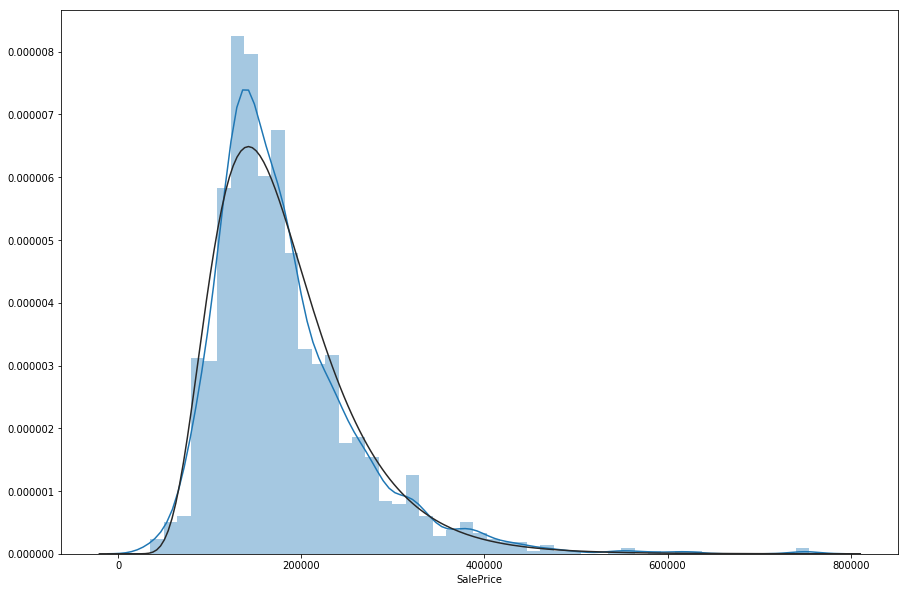

In [8]:
sns.distplot(training_data['SalePrice'], fit=stat.lognorm);

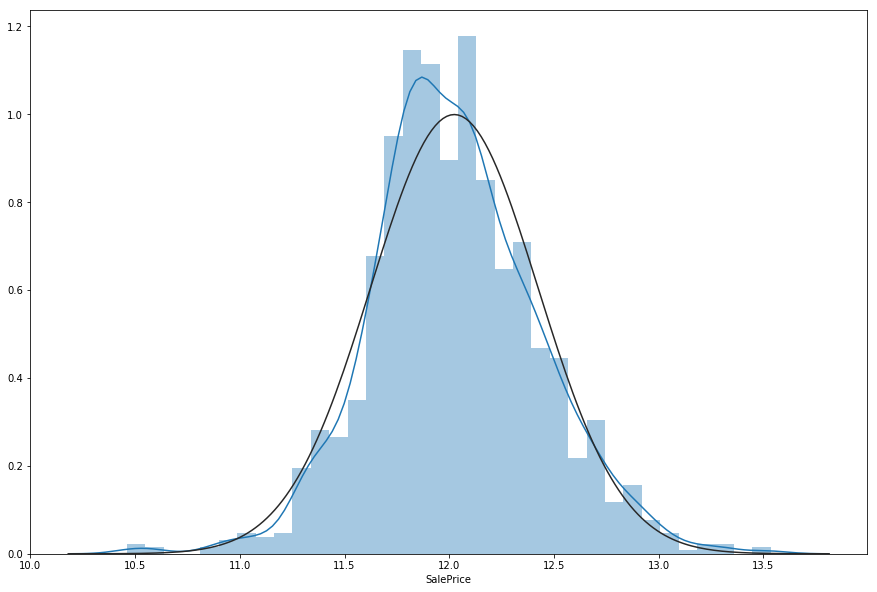

In [9]:
sns.distplot(np.log(training_data['SalePrice']), fit=stat.norm);

In [10]:
categorical_vars = training_data.select_dtypes(include=['category'])
real_vars = training_data.select_dtypes(include=['float64'])
count_vars = training_data.select_dtypes(include=['int64']).drop(columns=['Id'])

nominal_vars = []
ordinal_vars = []

for categorical_var in categorical_vars:
    if training_data[categorical_var].cat.ordered:
        ordinal_vars.append(training_data[categorical_var])
    else:
        nominal_vars.append(training_data[categorical_var])
        
nominal_vars = pd.DataFrame(nominal_vars).T
ordinal_vars = pd.DataFrame(ordinal_vars).T

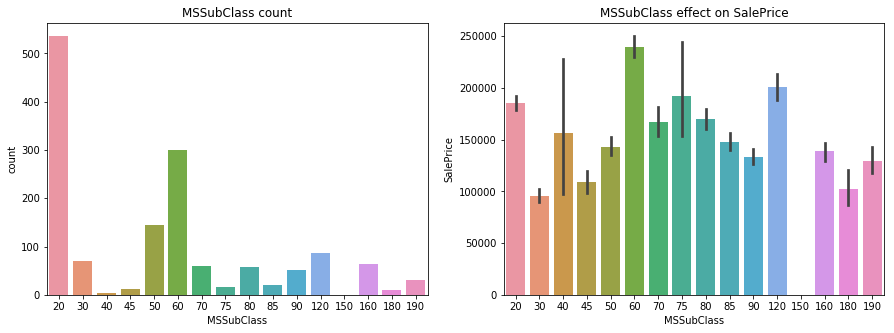

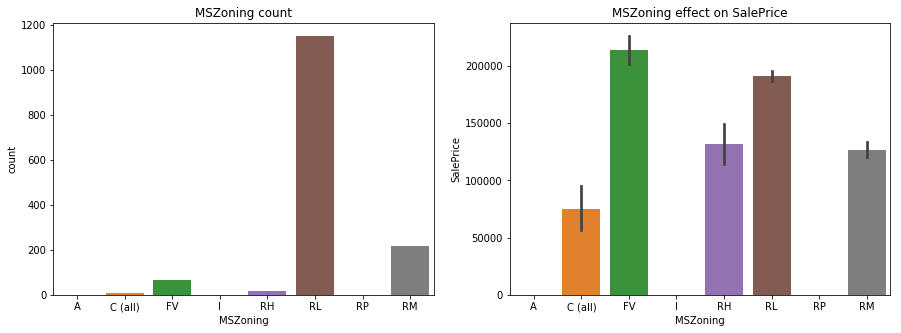

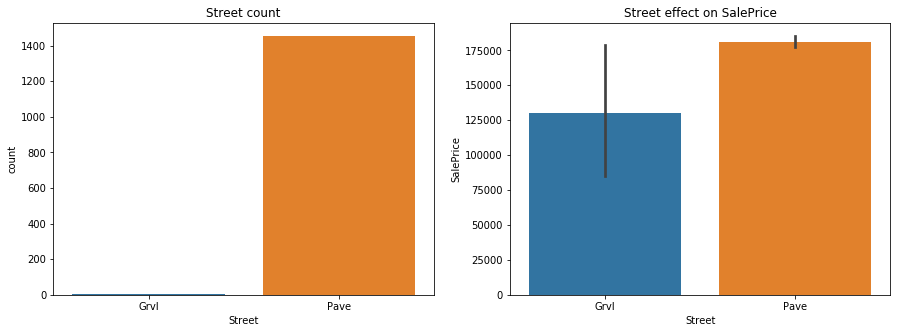

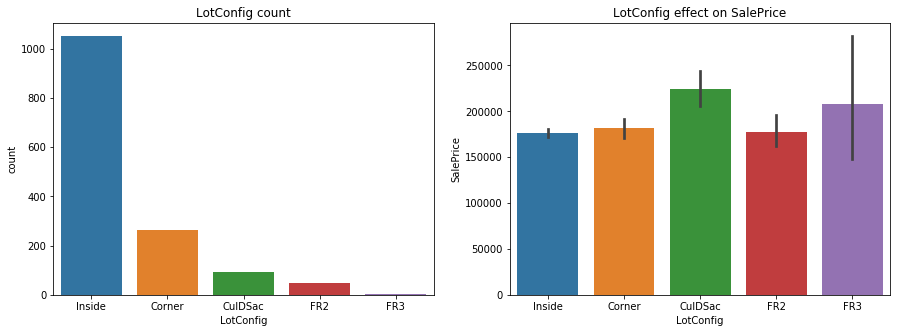

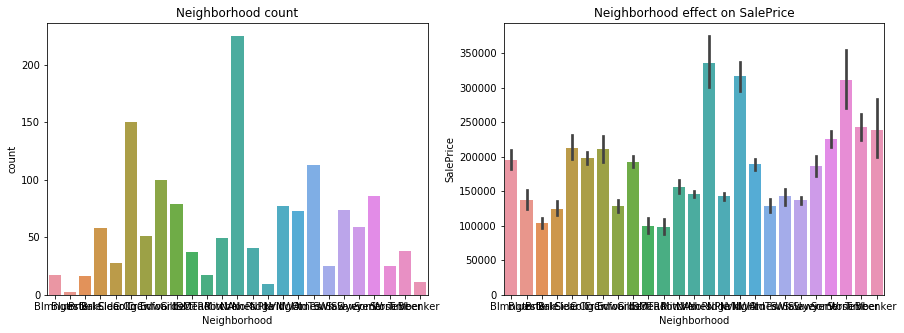

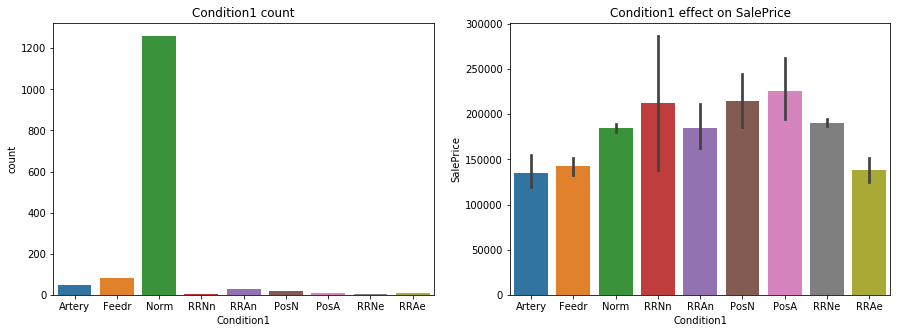

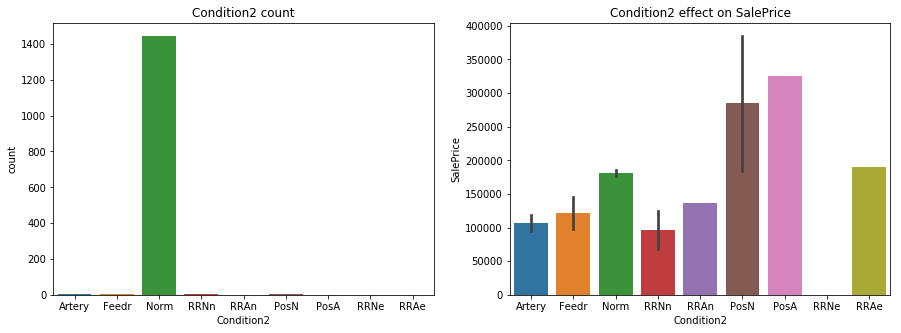

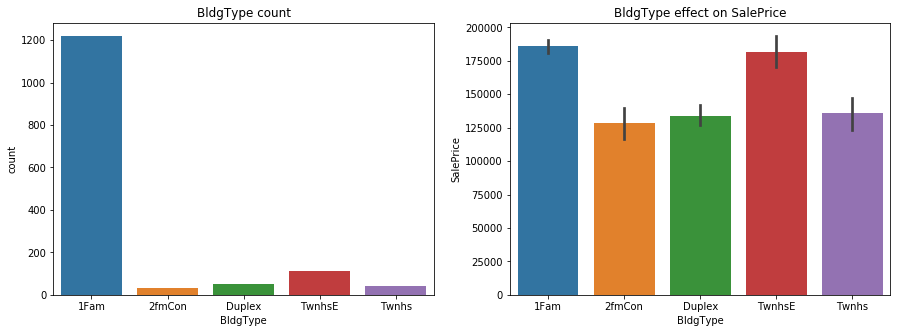

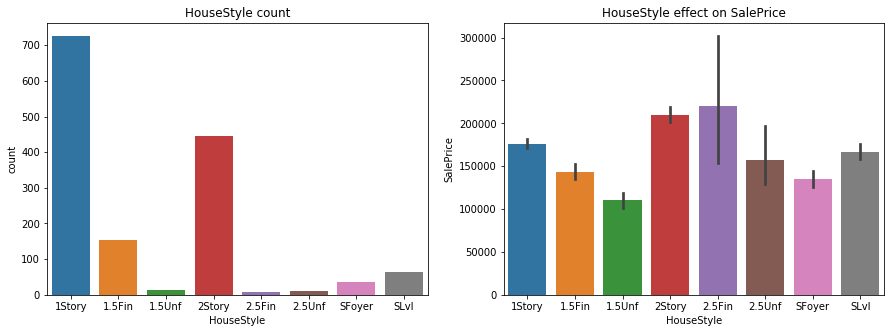

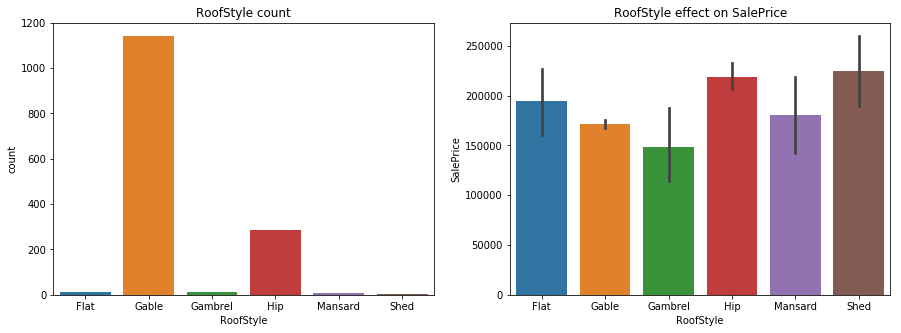

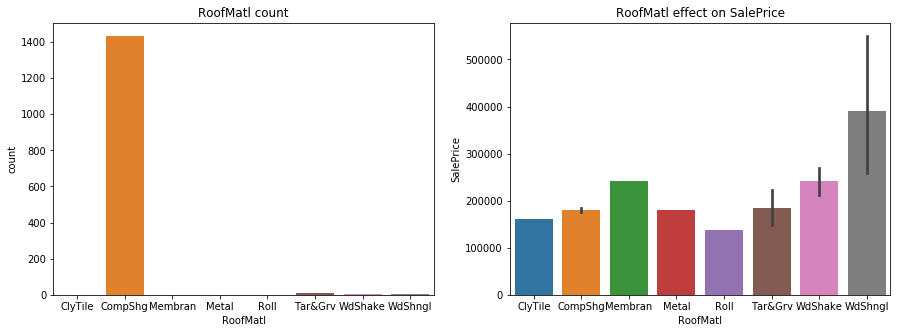

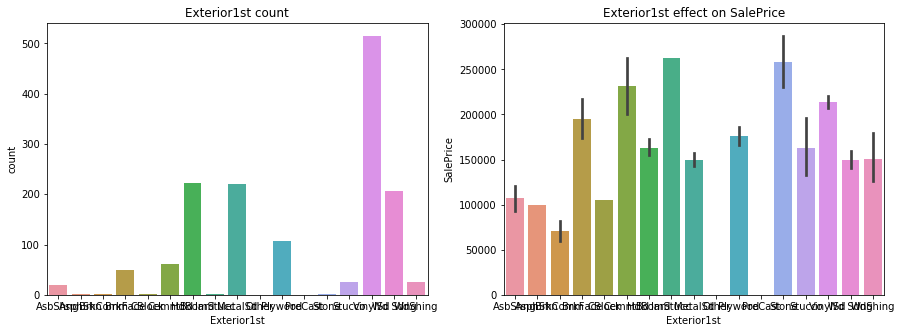

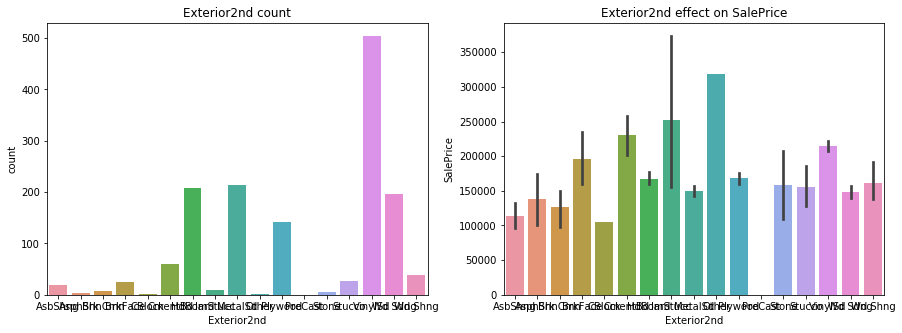

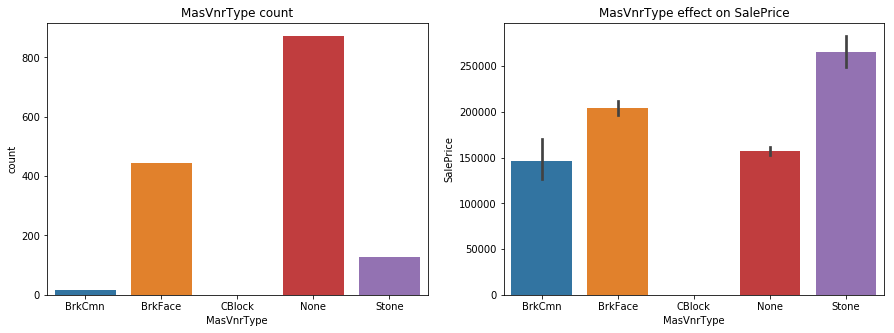

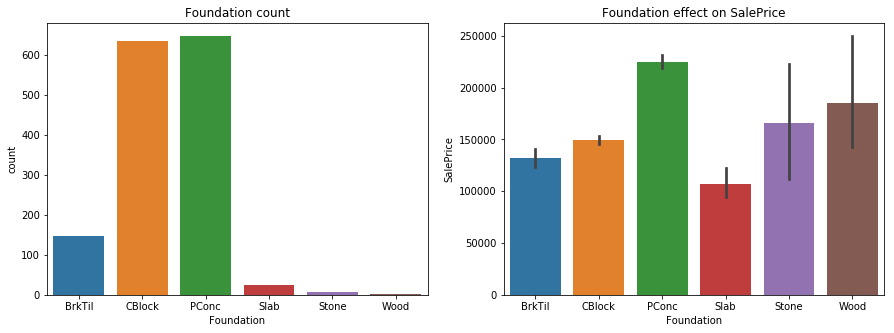

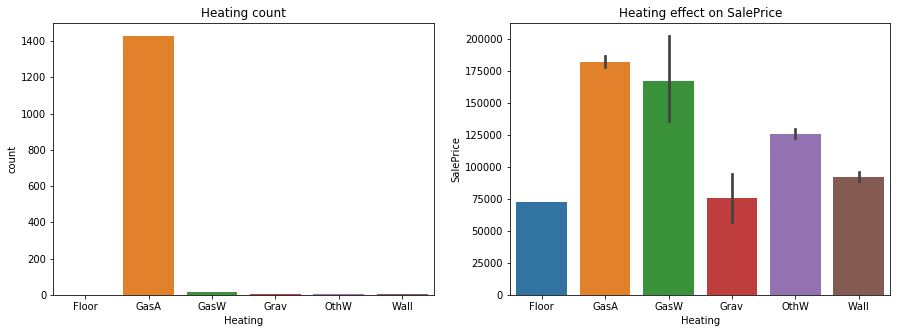

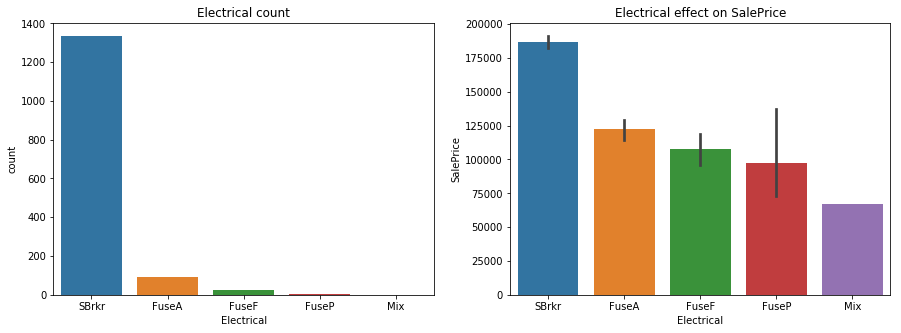

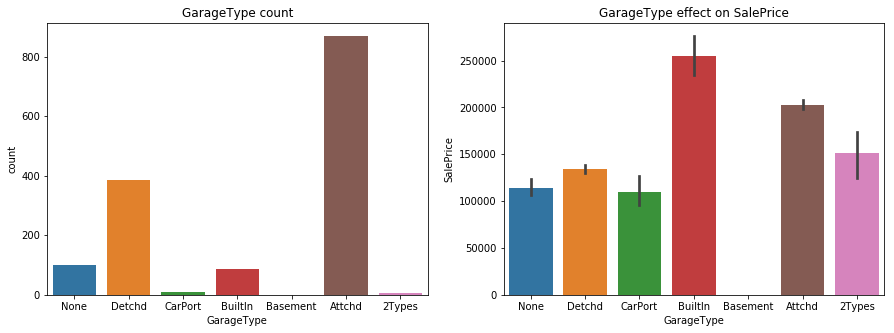

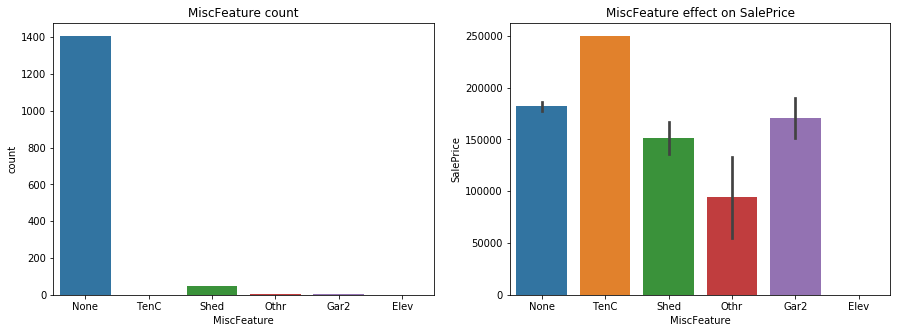

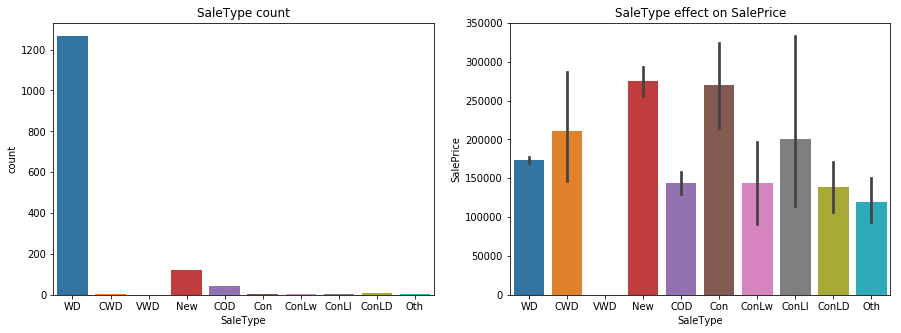

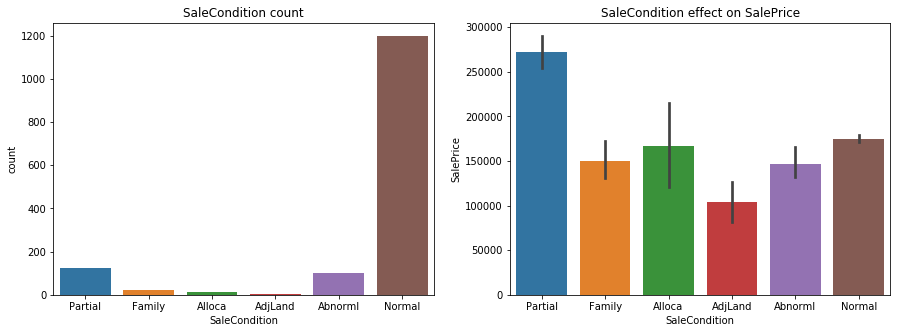

In [11]:
with plt.rc_context({'figure.figsize': (15, 5)}):
    for nominal_var in nominal_vars:
        plot_categorical(training_data[nominal_var], training_data['SalePrice'])

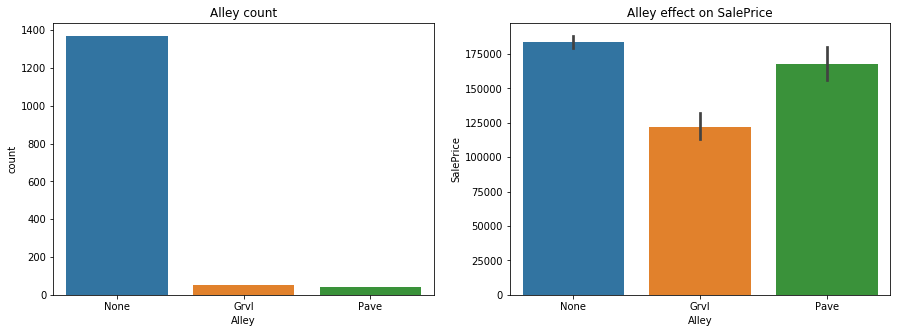

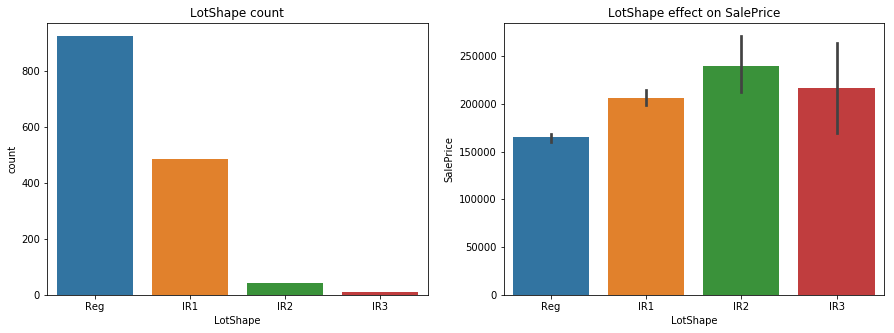

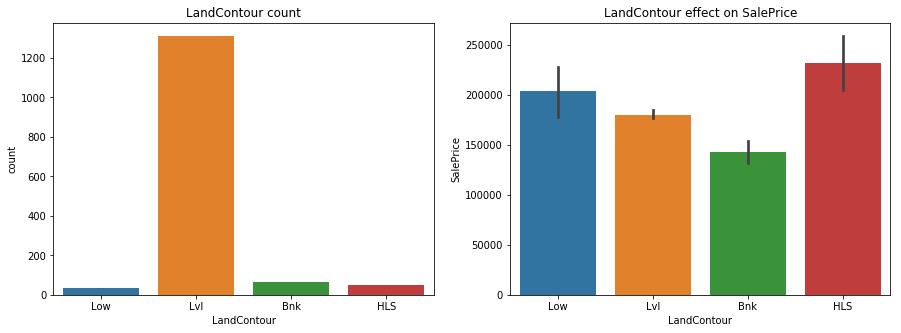

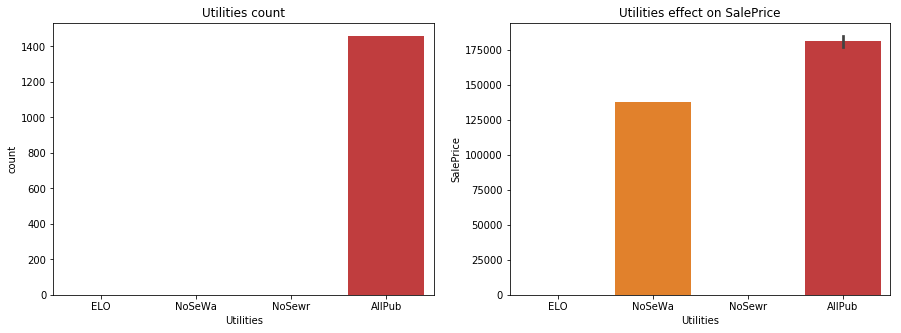

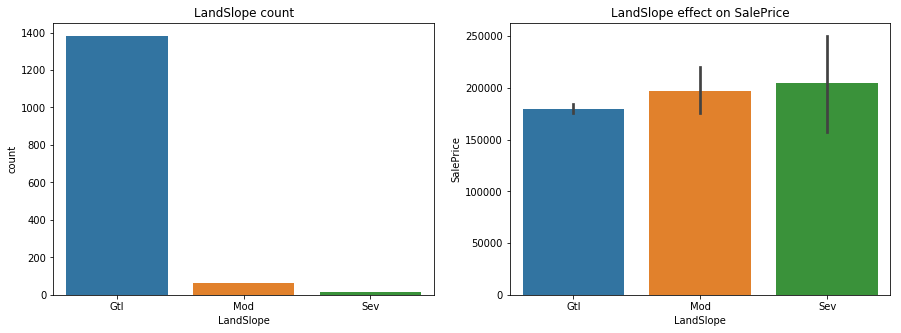

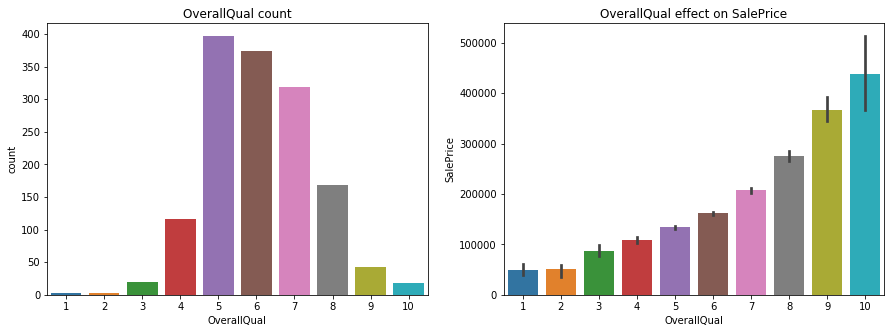

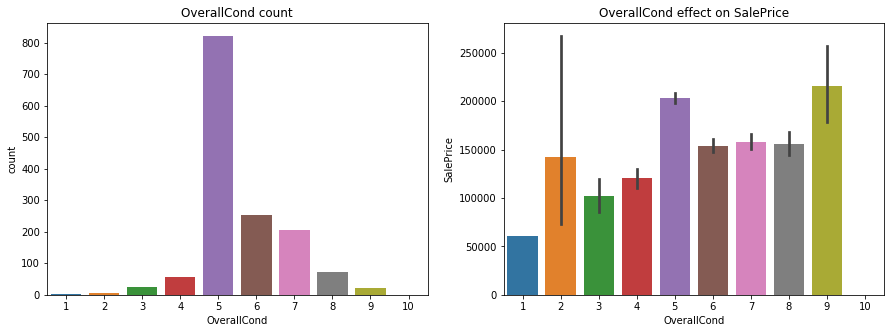

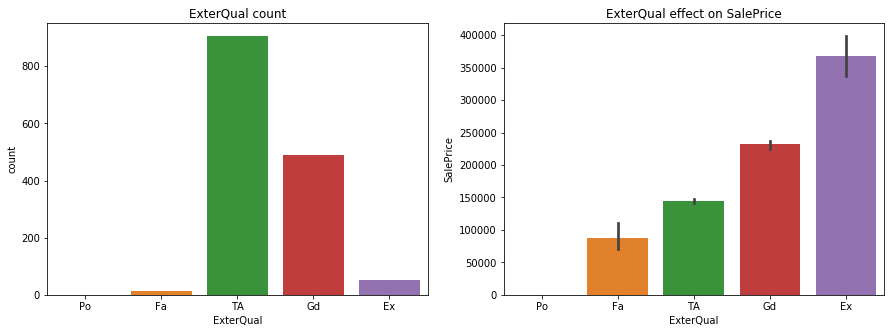

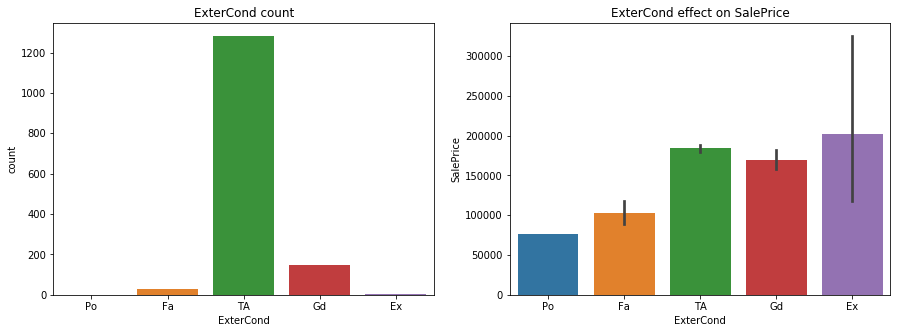

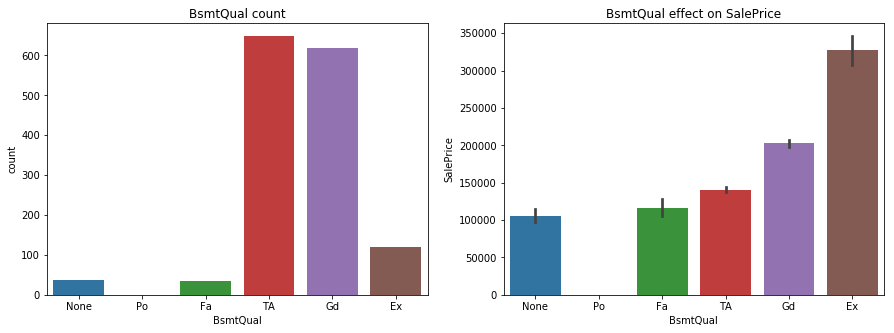

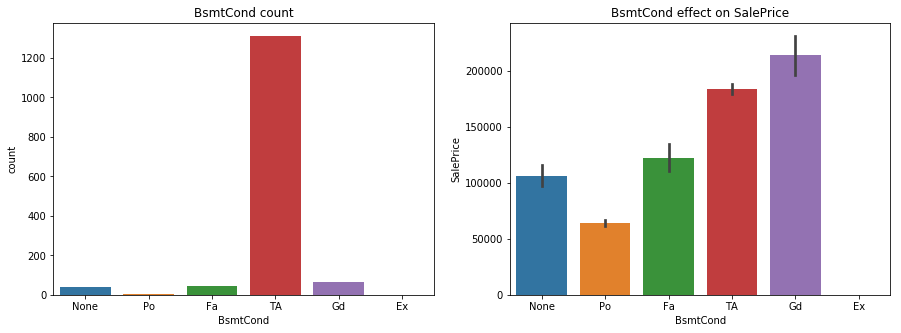

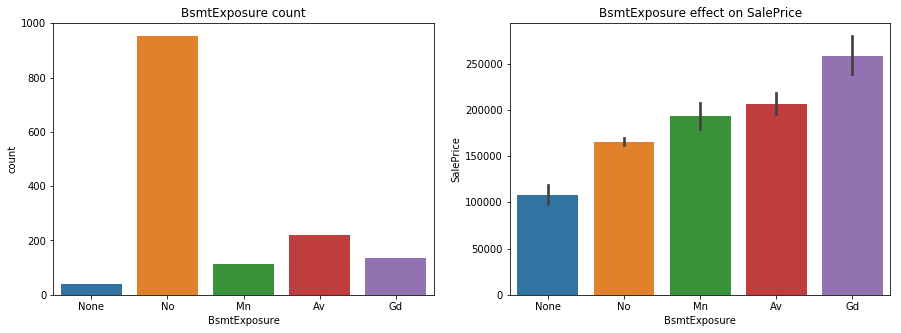

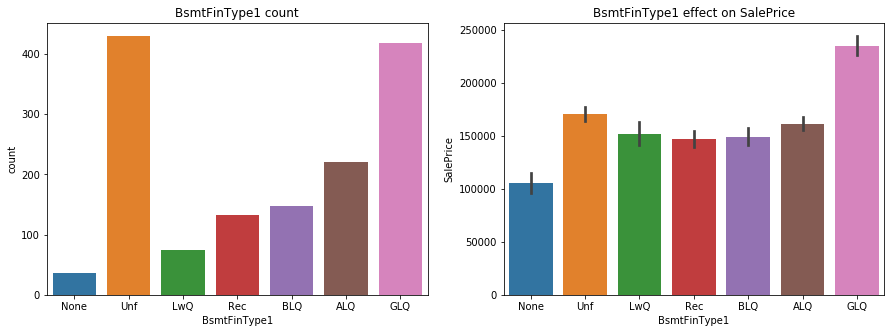

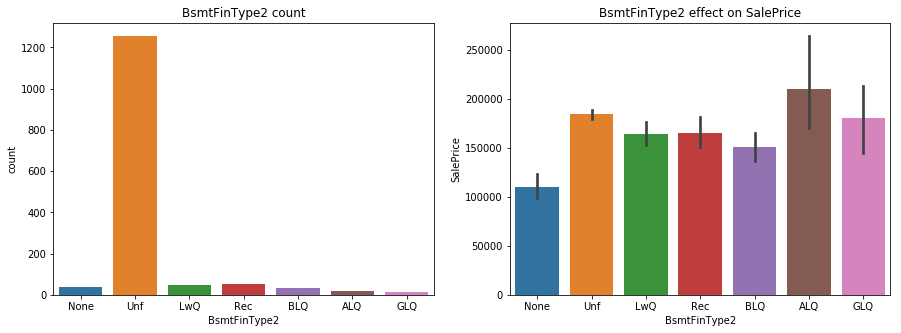

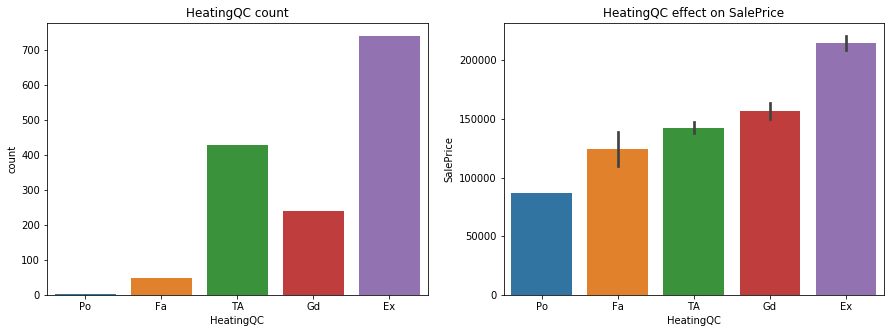

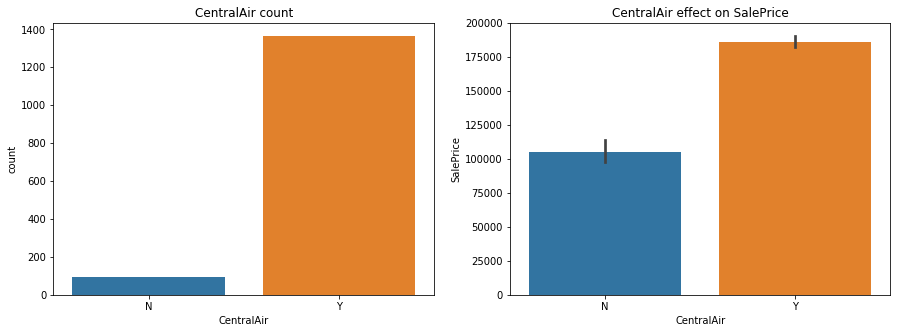

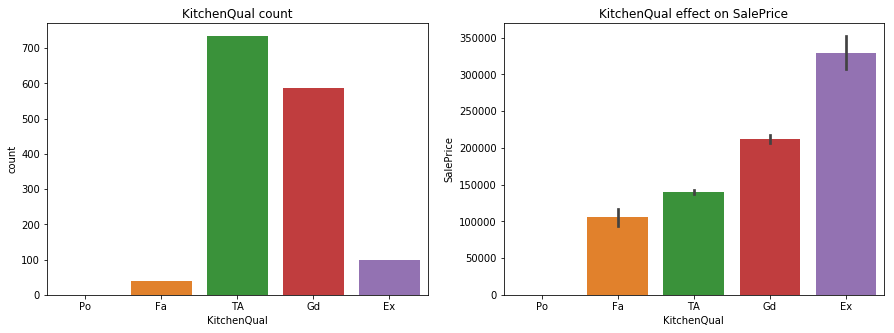

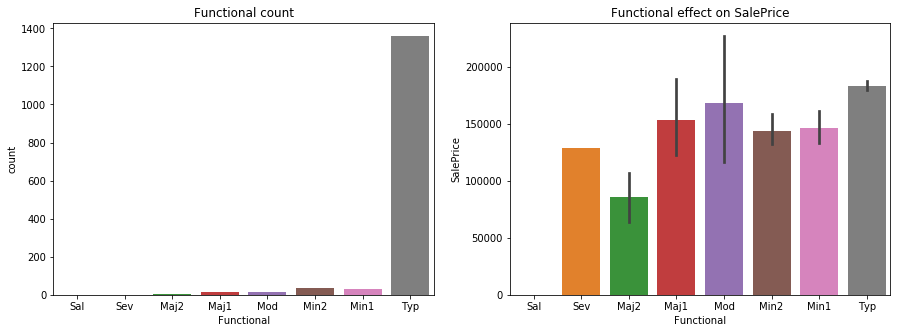

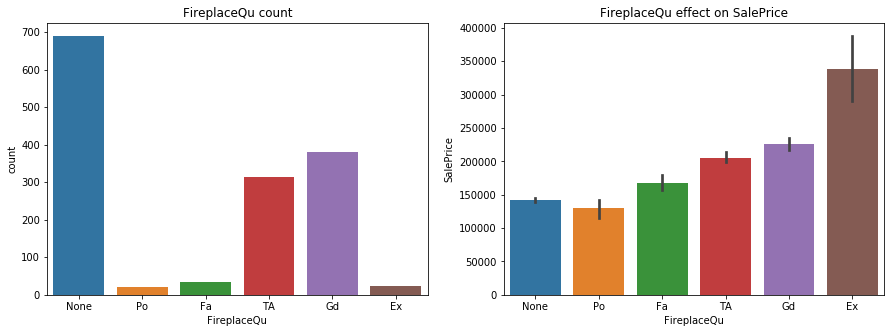

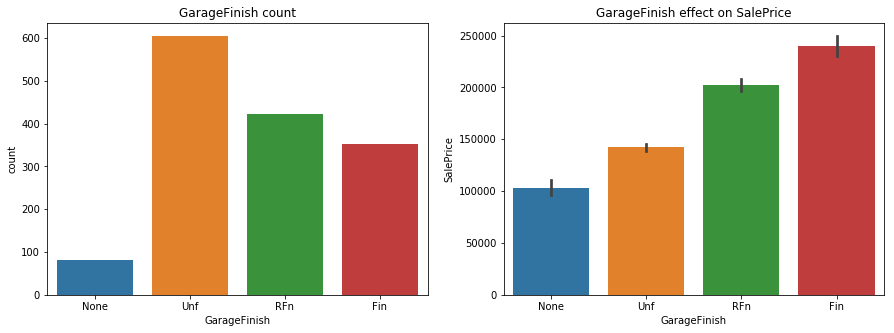

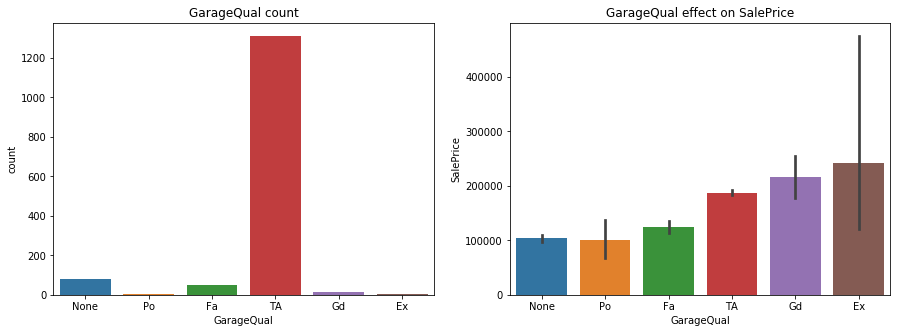

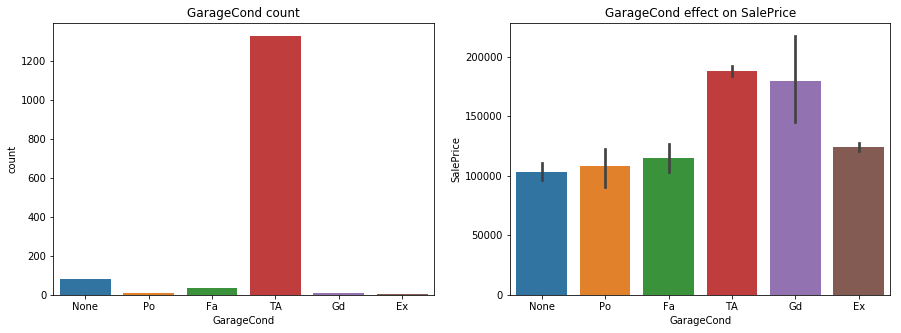

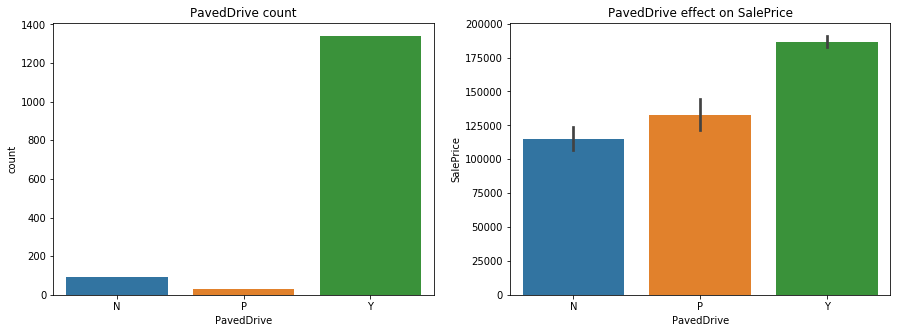

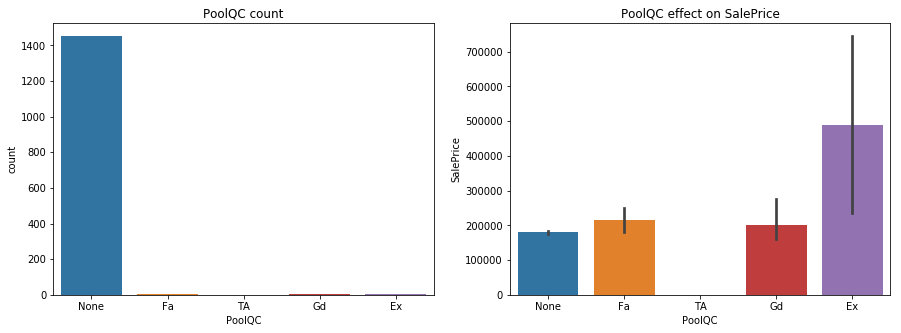

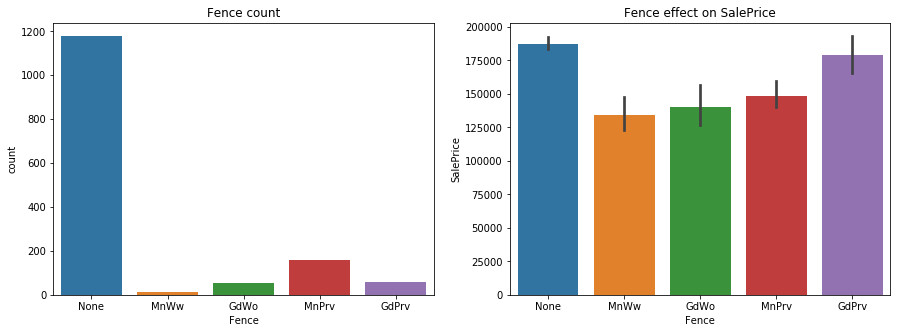

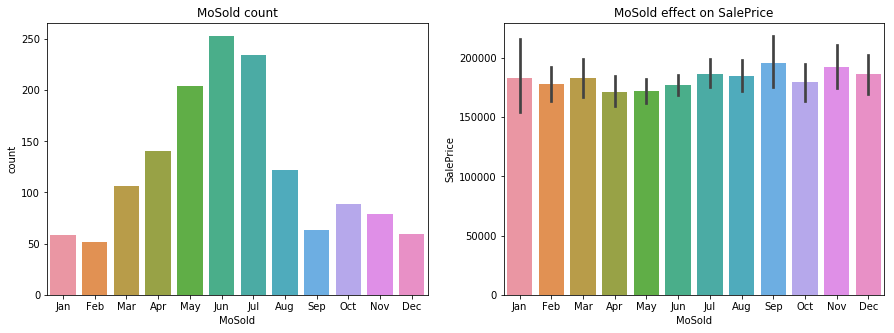

In [12]:
with plt.rc_context({'figure.figsize': (15, 5)}):
    for ordinal_var in ordinal_vars:
        plot_categorical(training_data[ordinal_var], training_data['SalePrice'])

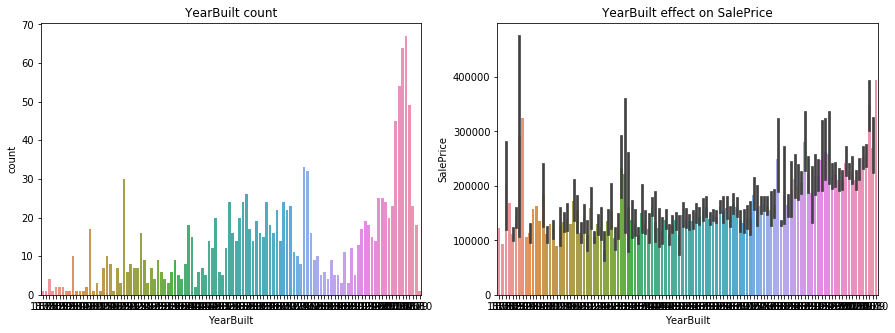

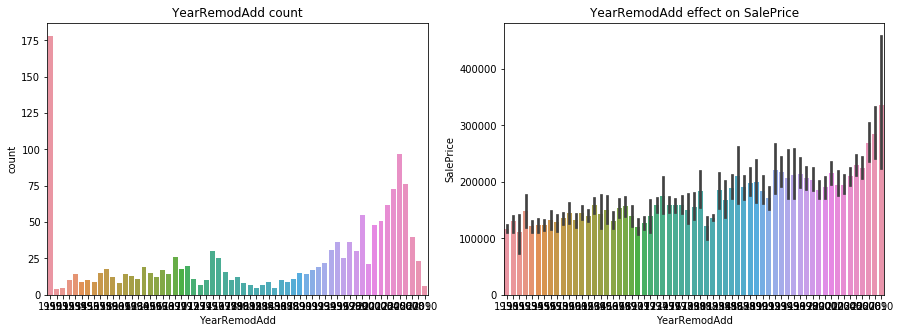

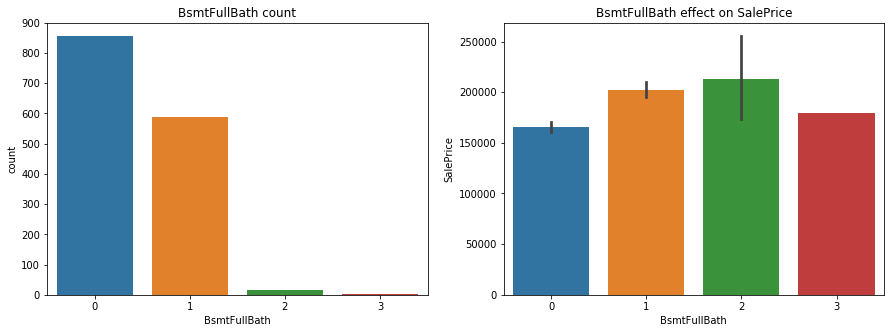

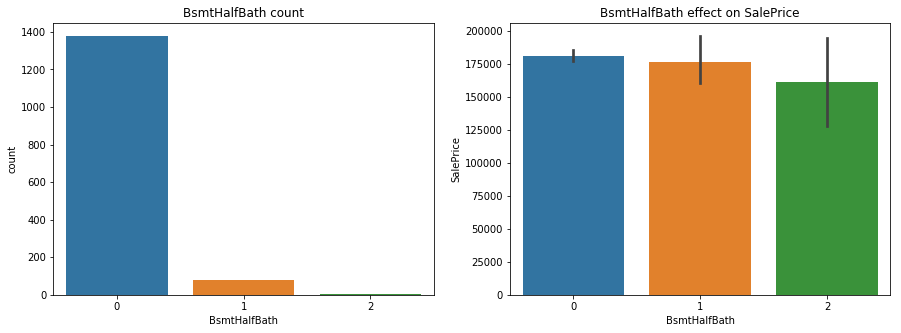

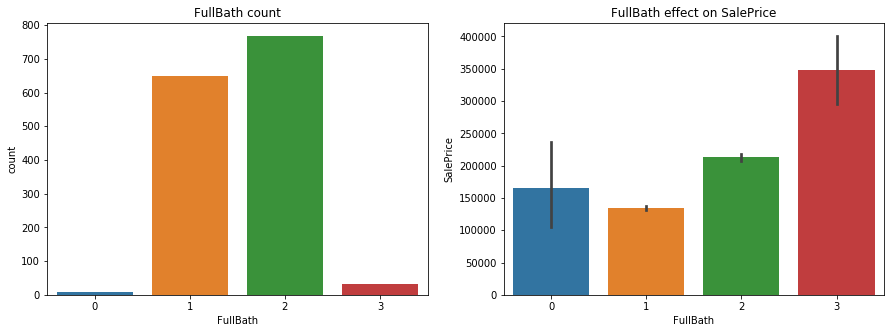

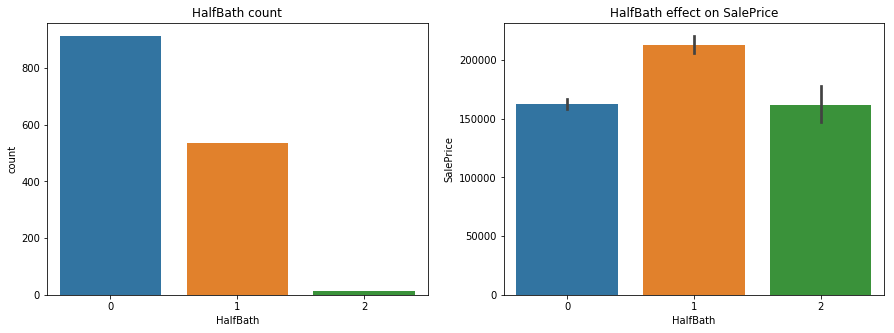

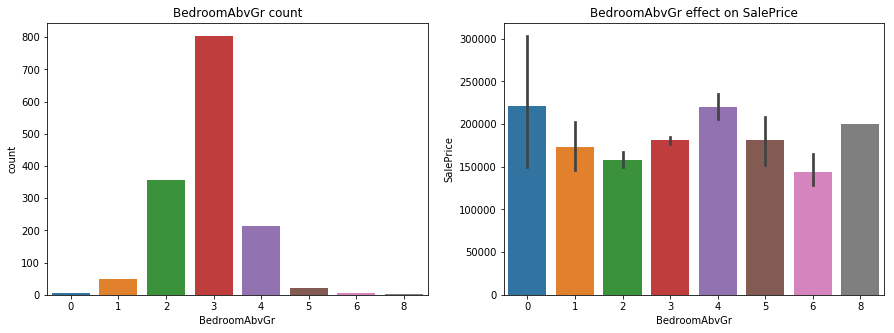

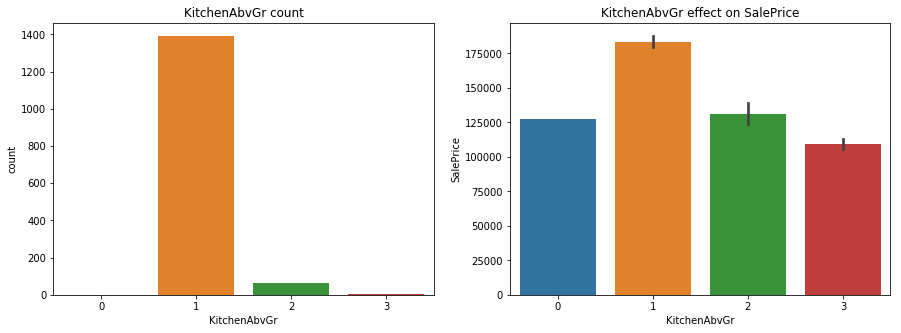

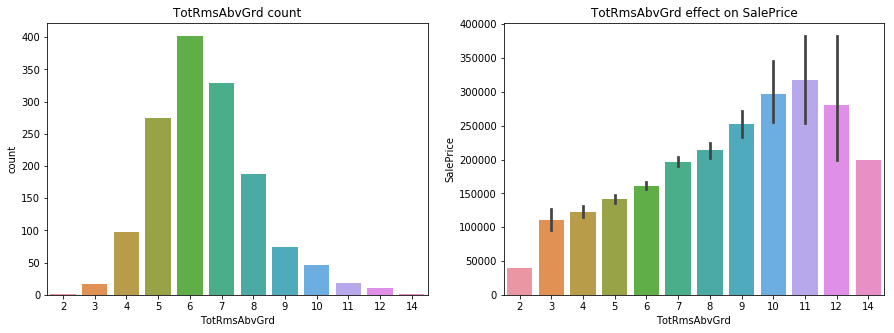

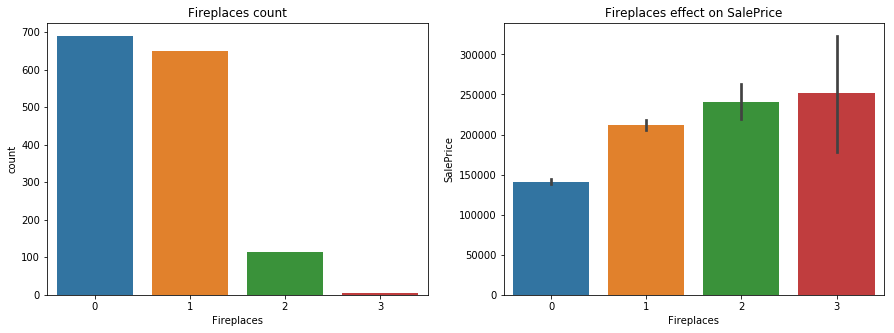

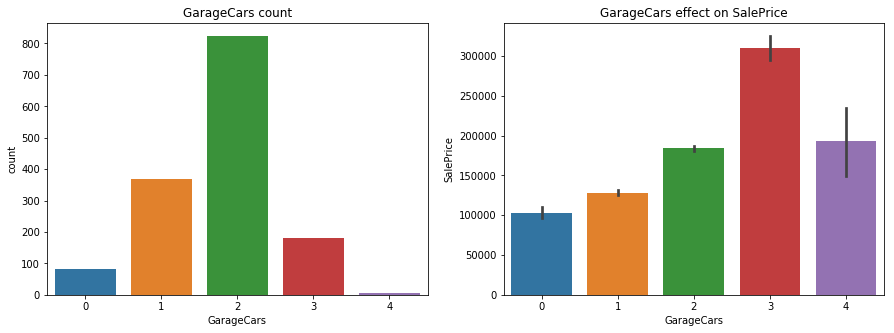

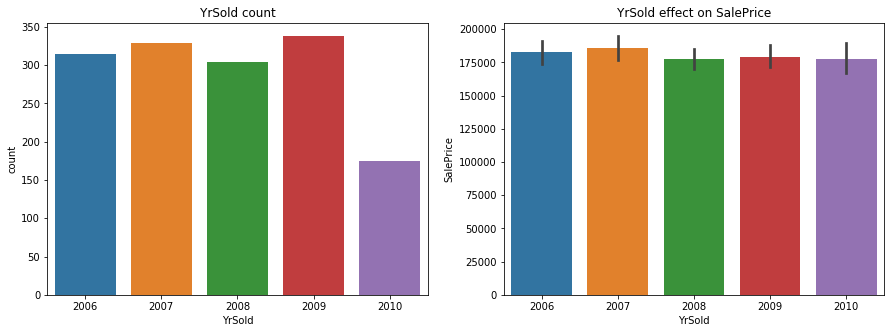

In [13]:
with plt.rc_context({'figure.figsize': (15, 5)}):
    for count_var in count_vars:
        plot_categorical(training_data[count_var], training_data['SalePrice'])

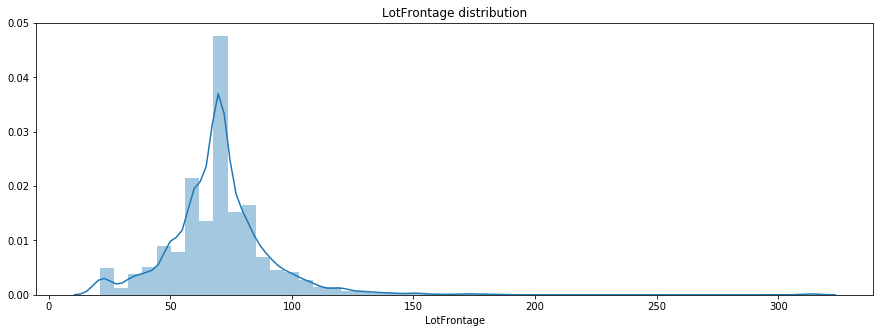

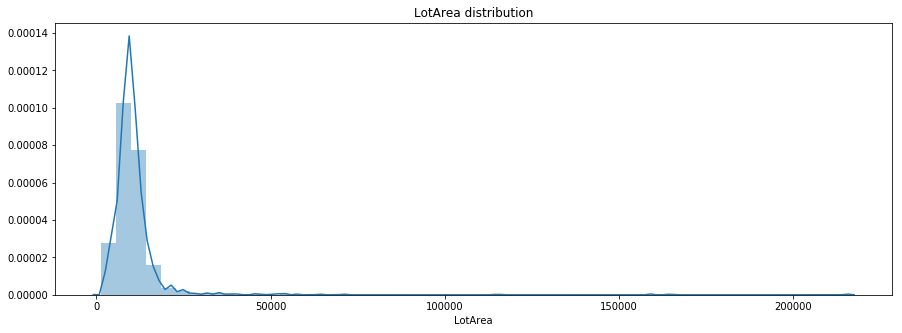

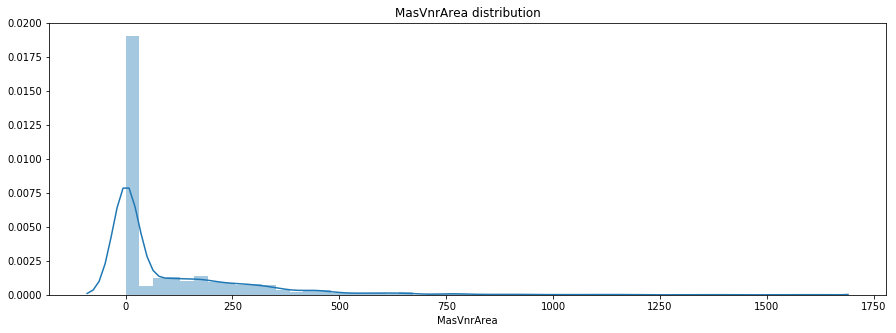

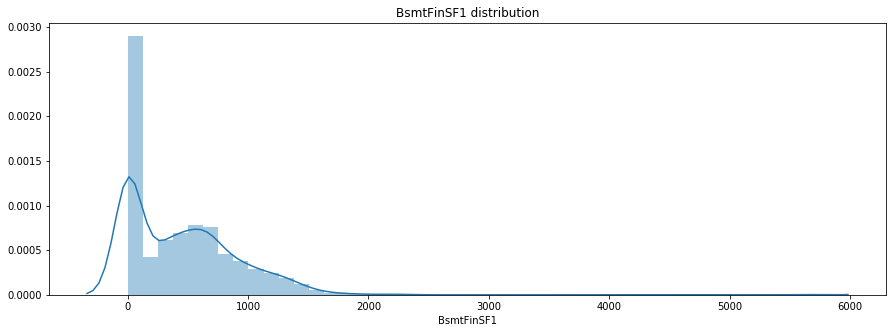

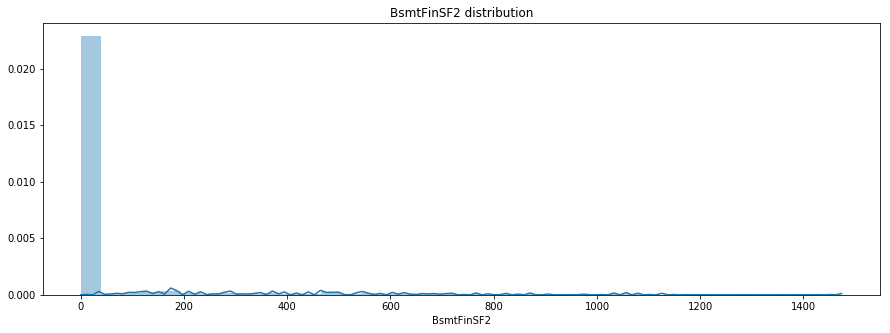

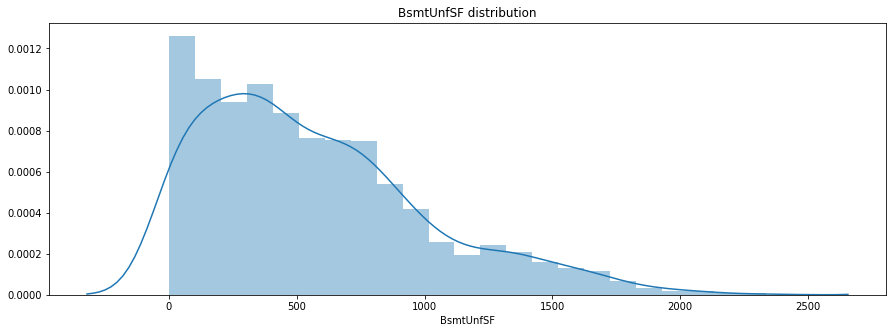

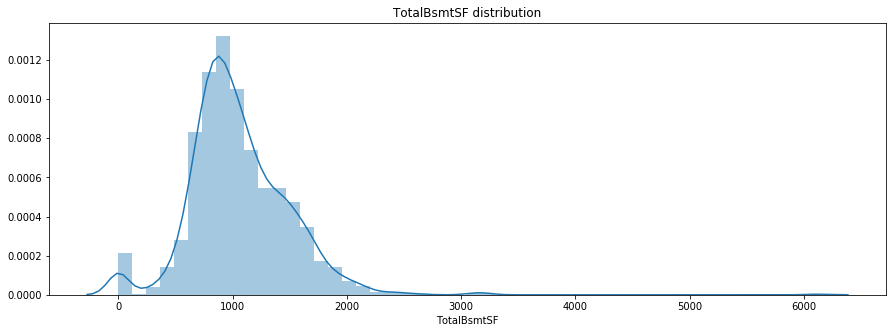

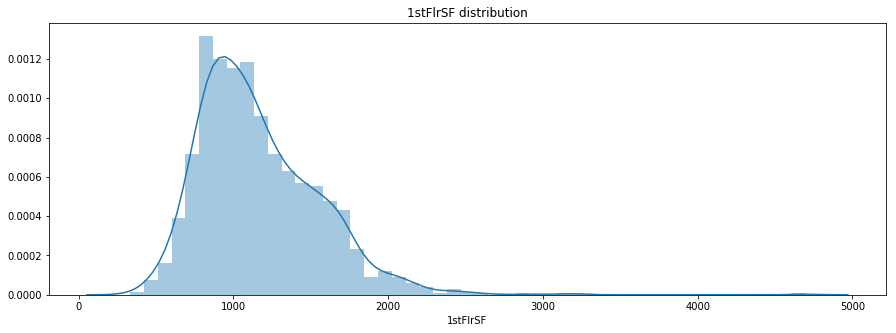

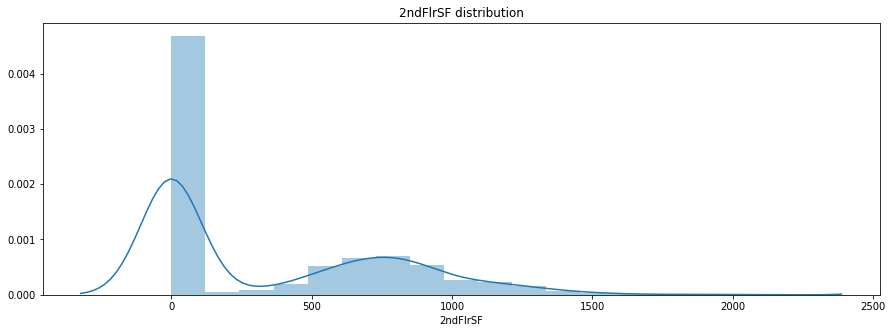

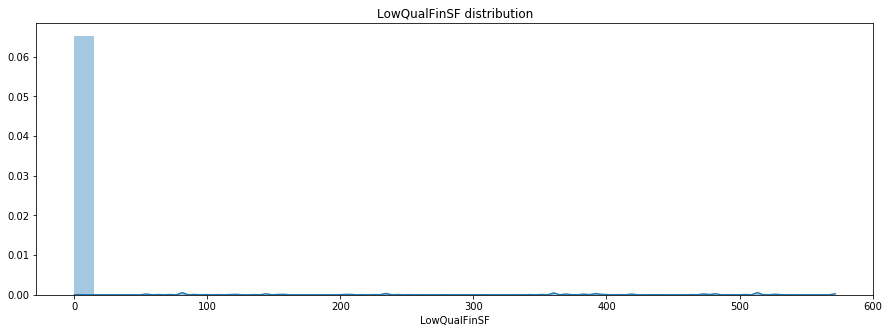

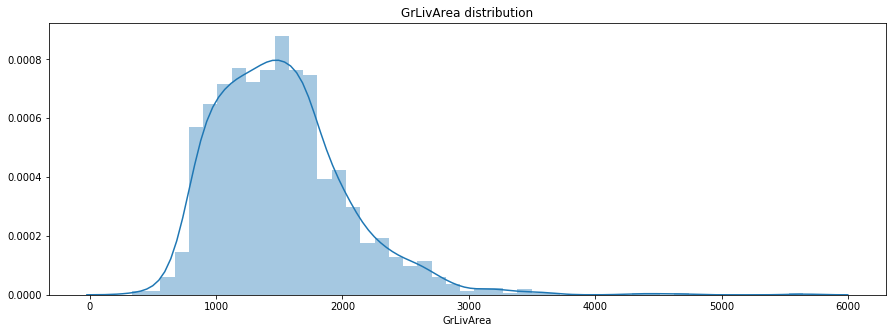

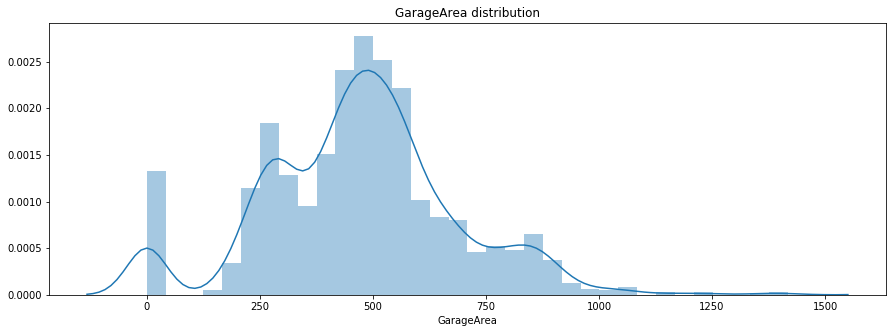

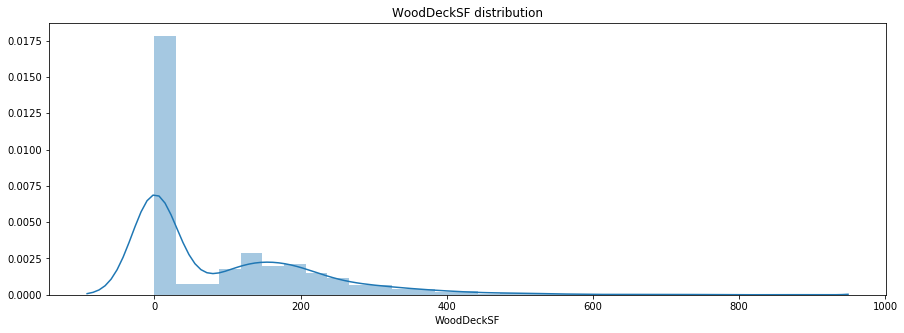

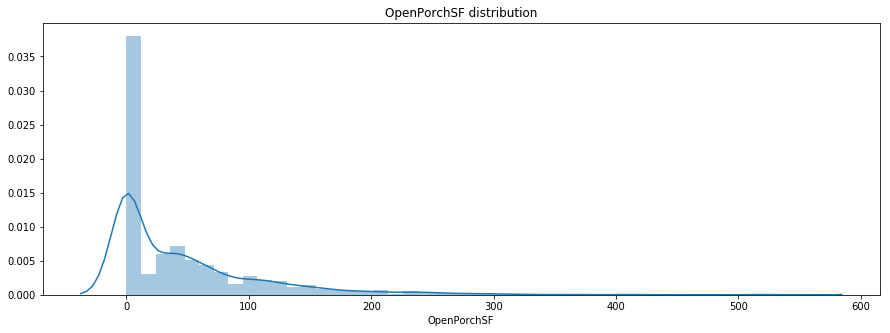

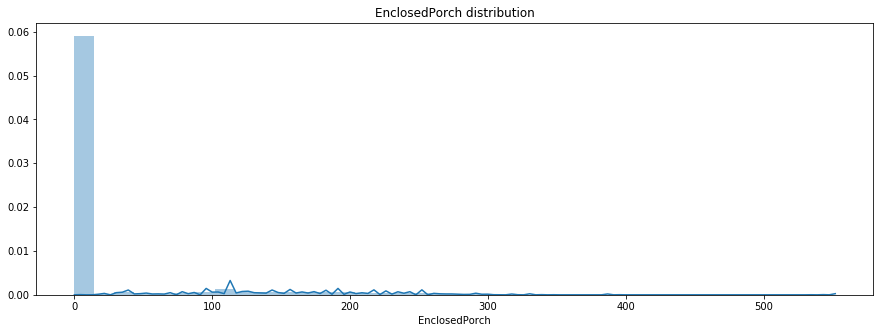

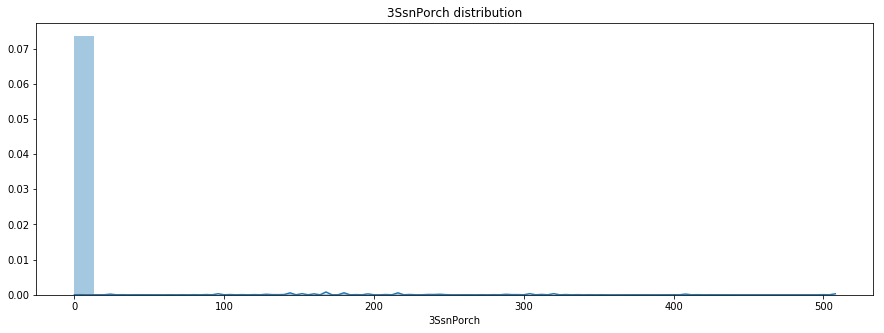

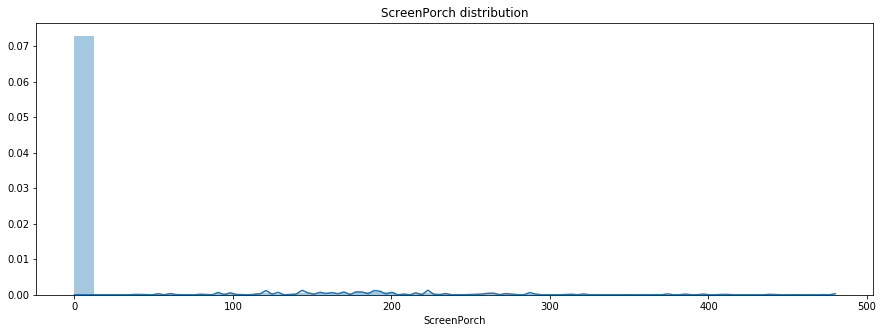

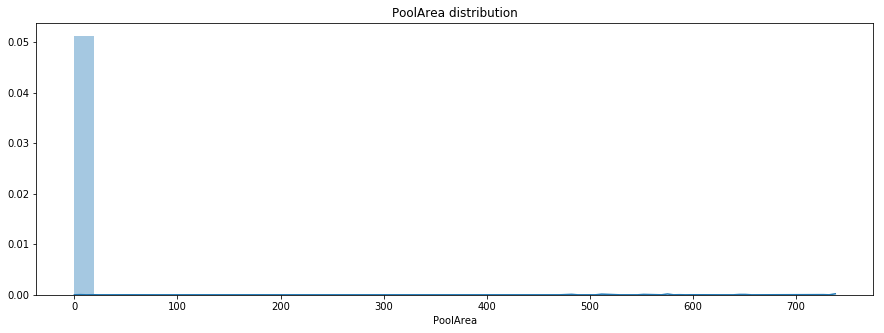

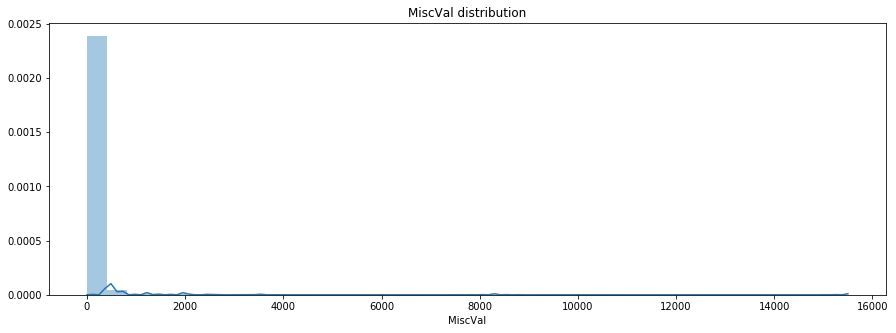

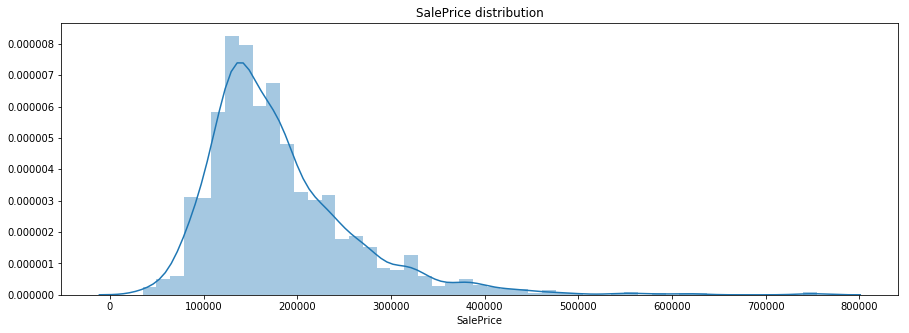

In [14]:
for real_var in real_vars:
    with plt.rc_context({'figure.figsize': (15, 5)}):
        plot_real(training_data[real_var])

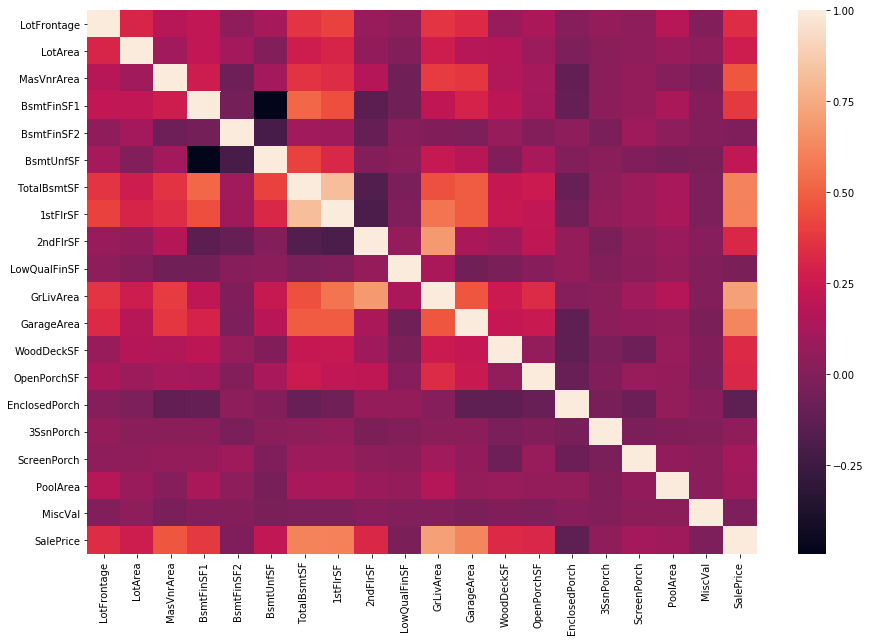

In [15]:
sns.heatmap(real_vars.corr());

In [16]:
real_vars.corr()['SalePrice'].sort_values(ascending=False)[1:]

GrLivArea        0.708624
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
MasVnrArea       0.472614
BsmtFinSF1       0.386420
LotFrontage      0.334901
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
LotArea          0.263843
BsmtUnfSF        0.214479
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
MiscVal         -0.021190
LowQualFinSF    -0.025606
EnclosedPorch   -0.128578
Name: SalePrice, dtype: float64

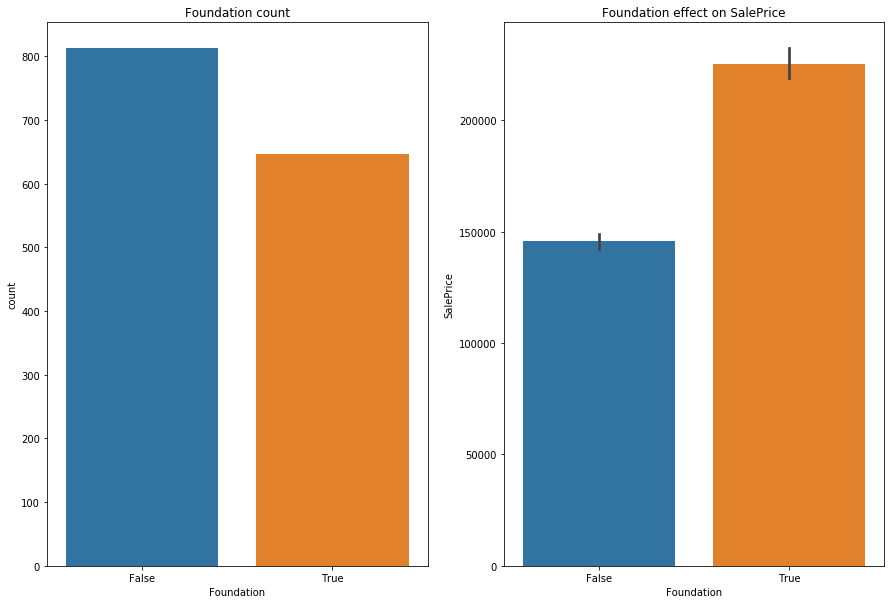

In [17]:
temp = training_data['Foundation'] == 'PConc'
plot_categorical(temp, training_data['SalePrice'])

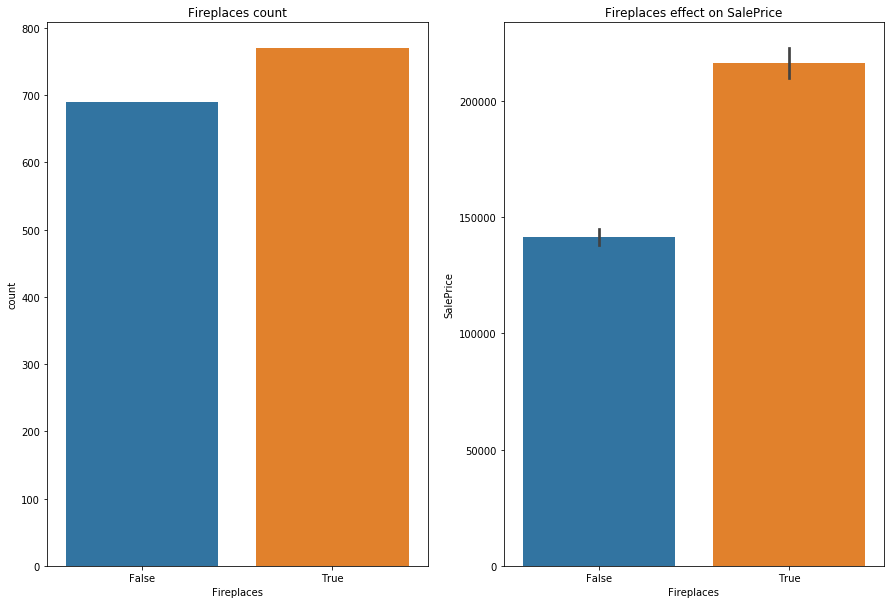

In [18]:
temp = training_data['Fireplaces'] != 0

plot_categorical(temp, training_data['SalePrice'])

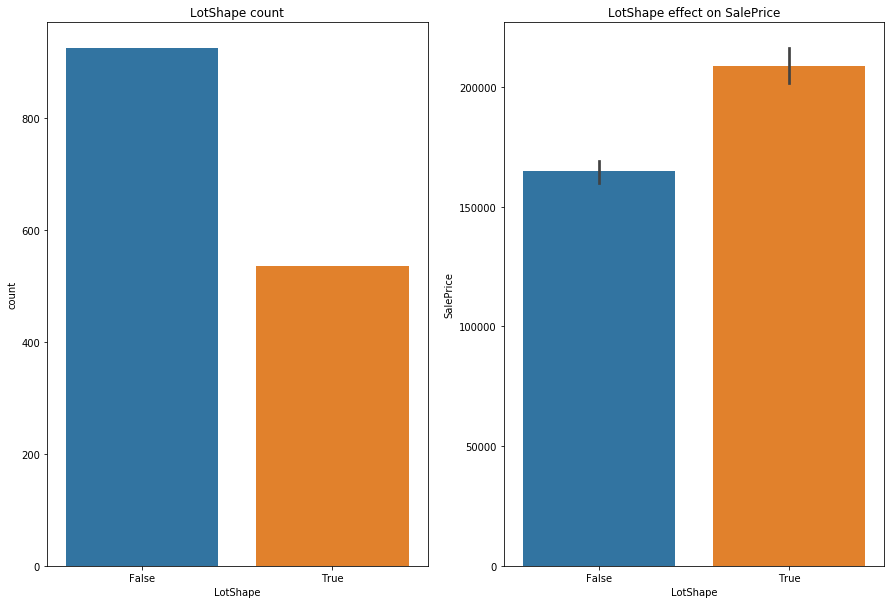

In [19]:
temp = training_data['LotShape'] != 'Reg'
plot_categorical(temp, training_data['SalePrice'])

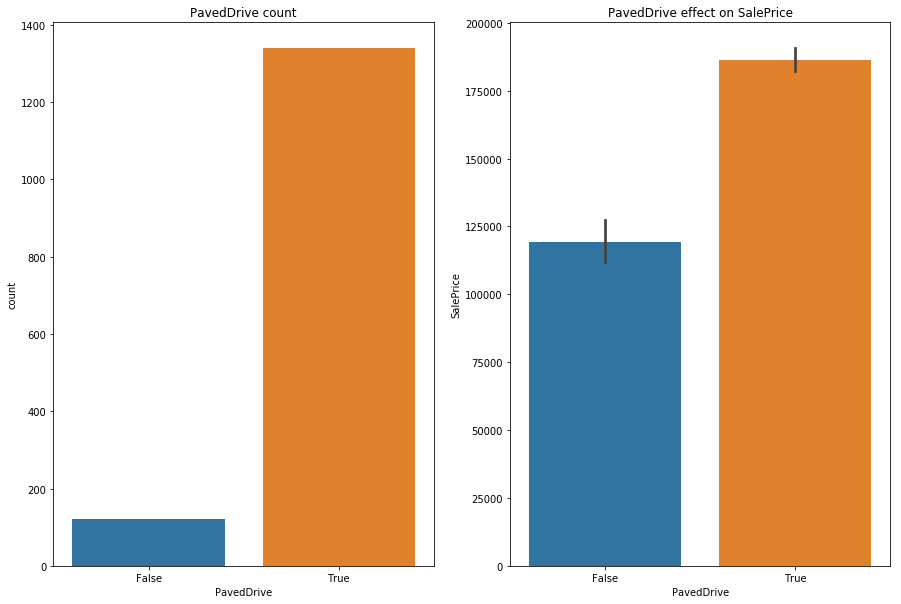

In [20]:
temp = training_data['PavedDrive'] == 'Y'
plot_categorical(temp, training_data['SalePrice'])

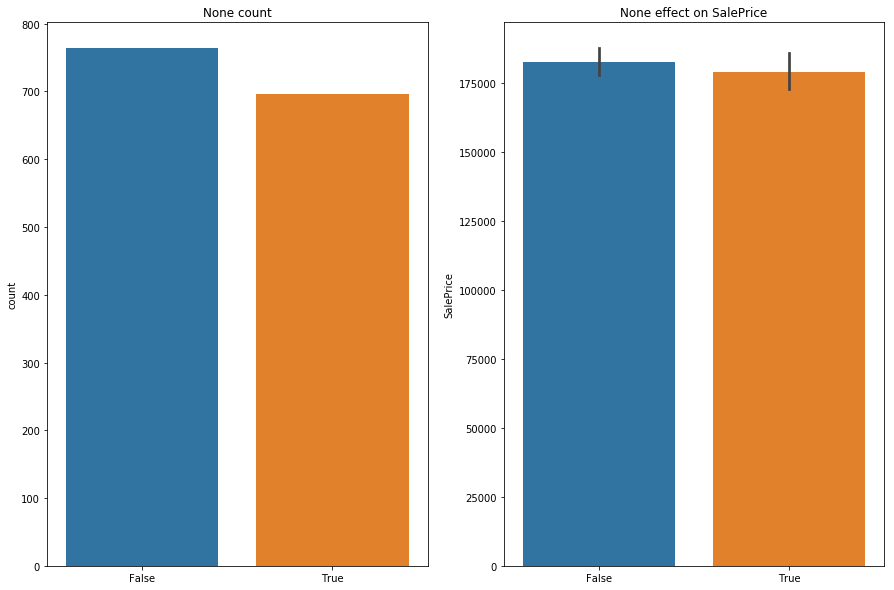

In [21]:
temp = training_data['YearRemodAdd'] != training_data['YearBuilt'] 
plot_categorical(temp, training_data['SalePrice'])

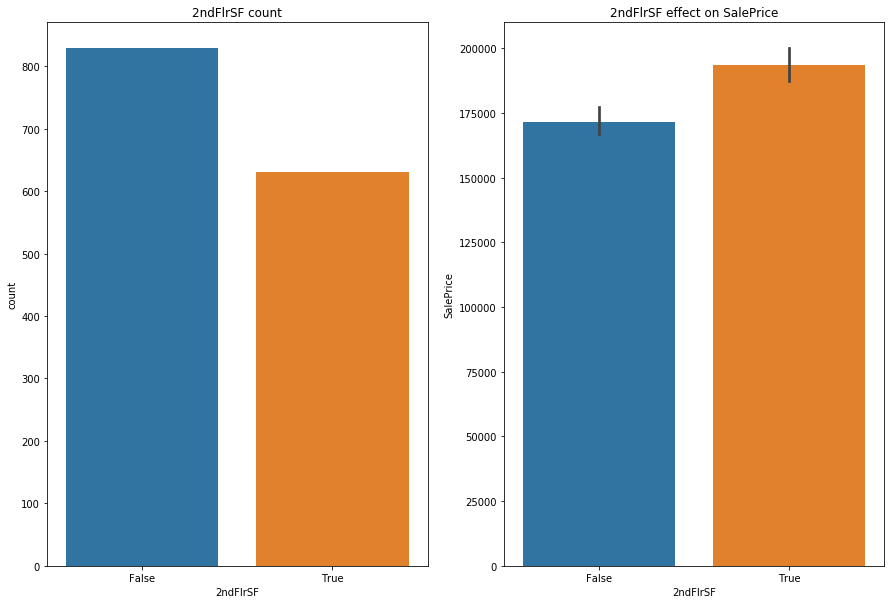

In [22]:
temp = training_data['2ndFlrSF'] > 0
plot_categorical(temp, training_data['SalePrice'])

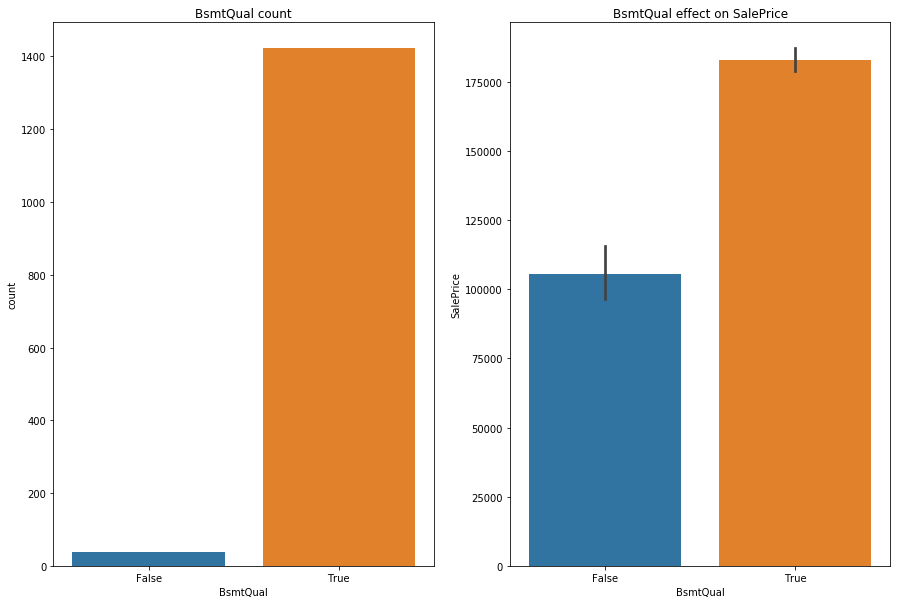

In [23]:
temp = training_data['BsmtQual'] != 'None'
plot_categorical(temp, training_data['SalePrice'])

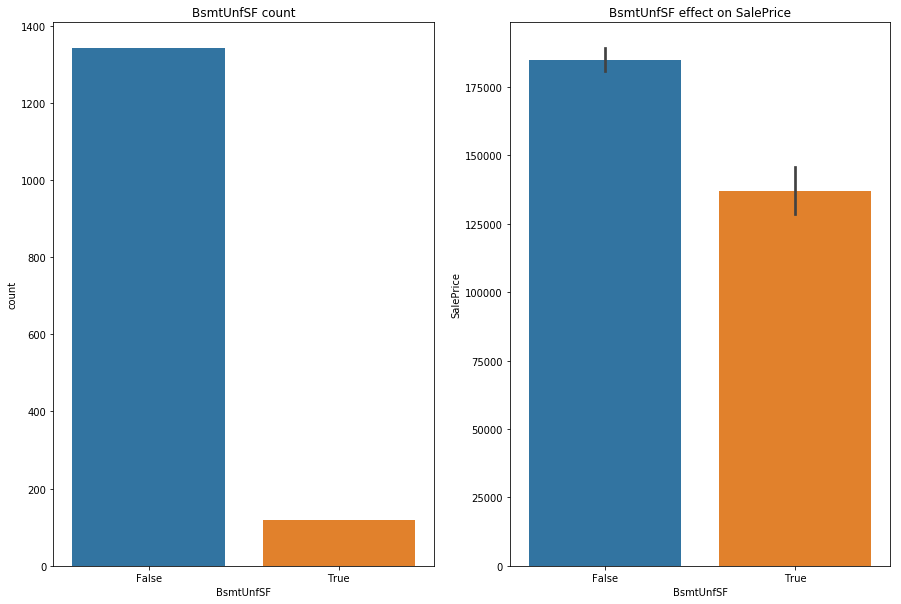

In [24]:
temp = training_data['BsmtUnfSF'] == 0
plot_categorical(temp, training_data['SalePrice'])

In [25]:
def finalize_features(data):
    
    df = data.copy()
    
    df['Fireplace'] = df['Fireplaces'] != 0
    df['FullyPavedDrive'] = df['PavedDrive'] == 'Y'
    df['IrregularLot'] = df['LotShape'] != 'Reg'
    df['PouredFoundation'] = df['Foundation'] == 'PConc'
    df['HasBasement'] = df['BsmtQual'] != 'None'
    df['Has2ndFloor'] = df['2ndFlrSF'] > 0
    
    df['TotalFullBath'] = df['FullBath'] + df['BsmtFullBath']
    df['TotalHalfBath'] = df['HalfBath'] + df['BsmtHalfBath']
    
    df['TotalBsmtSF'] = np.log1p(df['TotalBsmtSF'])
    df['GrLivArea'] = np.log1p(df['GrLivArea'])
    df['1stFlrSF'] = np.log1p(df['1stFlrSF'])
    df['WoodDeckSF'] = np.log1p(df['WoodDeckSF'])
    
    features_to_drop = [
        'Id',
        'MoSold',
        'EnclosedPorch',
        'LowQualFinSF',
        'MiscVal',
        '3SsnPorch',
        'PoolArea',
        'ScreenPorch',
        'BsmtUnfSF',
        'Fireplaces',
        'PavedDrive',
        'LotShape',
        'Foundation',
        'BsmtQual',
        '2ndFlrSF'
    ]

    return pd.get_dummies(df.drop(columns=features_to_drop))

def kaggle_scoring(estimator, X, y):
    predicted_y = estimator.predict(X)
    return np.sqrt(mean_squared_log_error(y_true=y, y_pred=predicted_y))

In [26]:
X = finalize_features(training_data.drop(columns='SalePrice'))
test = finalize_features(test_data)
y = np.log(training_data['SalePrice'])

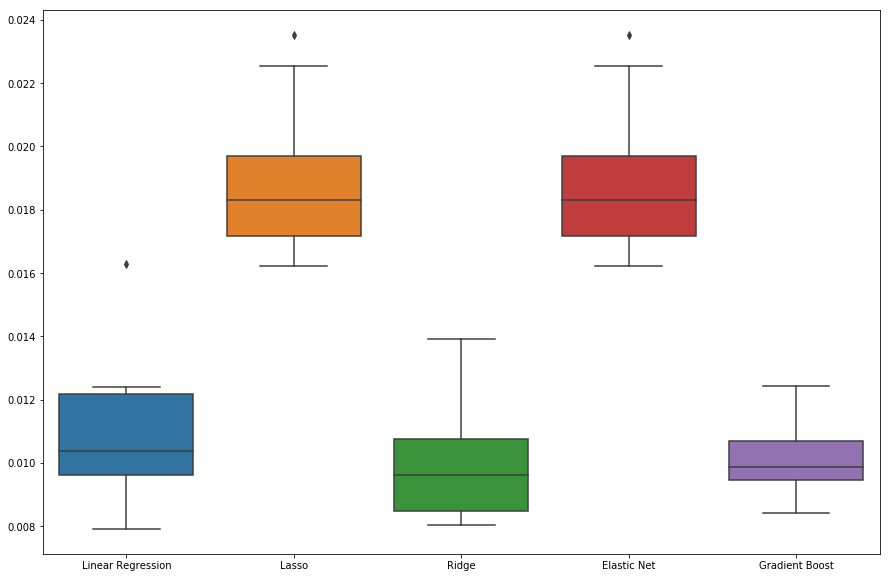

In [27]:
estimators = [LinearRegression(), LassoCV(), RidgeCV(), ElasticNetCV(), GradientBoostingRegressor(loss='huber')]
est_names = ['Linear Regression', 'Lasso', 'Ridge', 'Elastic Net', 'Gradient Boost']

cv_data = pd.DataFrame()

for estimator, estimator_name in zip(estimators, est_names):
    cv_data[estimator_name] = cross_val_score(estimator=estimator, X=X, y=y, cv=10, scoring=kaggle_scoring)
    
sns.boxplot(data=cv_data);

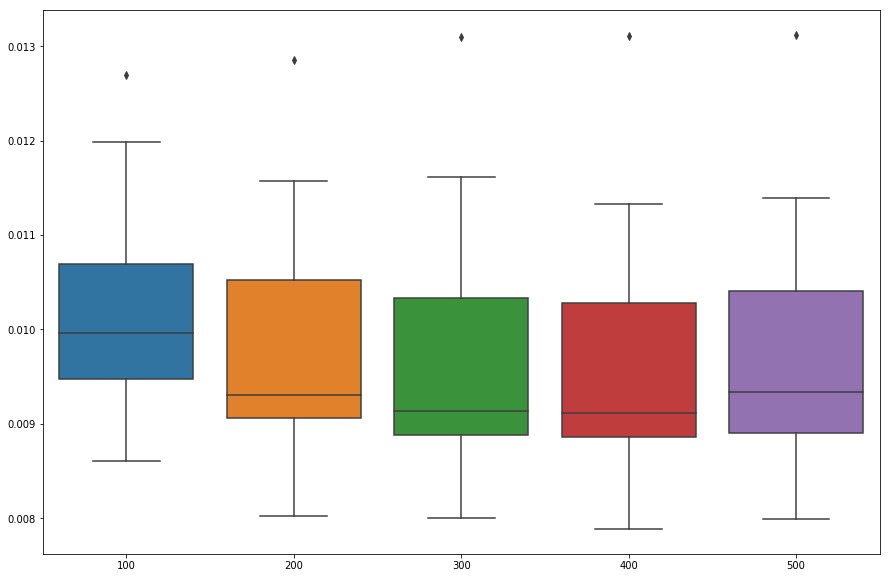

In [28]:
grad_boost_data = pd.DataFrame()

for n_estimators in range(100, 600, 100):
    grad_boost = GradientBoostingRegressor(n_estimators=n_estimators, loss='huber')
    grad_boost_data[n_estimators] = cross_val_score(estimator=grad_boost, X=X, y=y, cv=10, scoring=kaggle_scoring)
    
sns.boxplot(data=grad_boost_data)

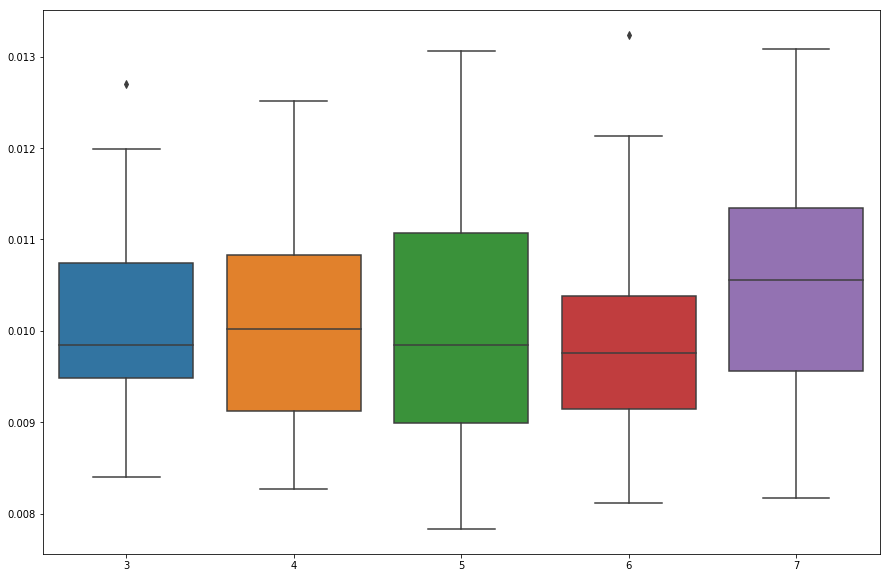

In [29]:
grad_boost_data = pd.DataFrame()

for max_depth in range(3, 8):
    grad_boost = GradientBoostingRegressor(max_depth=max_depth, loss='huber')
    grad_boost_data[max_depth] = cross_val_score(estimator=grad_boost, X=X, y=y, cv=10, scoring=kaggle_scoring)
    
sns.boxplot(data=grad_boost_data)

In [30]:
grad_boost = GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='huber')
grad_boost.fit(X, y)
result = np.exp(grad_boost.predict(test))
submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':result})
submission.to_csv('submission.csv', index=False)

In [31]:
grad_boost = GradientBoostingRegressor()
y = np.log(training_data['SalePrice'])
X = pd.get_dummies(training_data.drop(columns=['SalePrice']))